## Text Classification with Logistic Regression

The project performed as an Assignment in Natural Language Processing course at the University of Sheffield


### Part 1: Sentiment  analyis of movie reviews

The data  are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) 

**Text processing methods:**
- extracting Bag-Of-Word features, using unigrams, bigrams and trigrams to obtain vector representations of documents.  - two vector weighting schemes: raw frequencies for each ngram type; tf.idf

**ML model:** Binary Logistic Regression classifiers trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted). 

**ML models' training** The Stochastic Gradient Descent (SGD):
    - Minimise the Binary Cross-entropy loss function
    - Use L2 regularisation 
    - Perform multiple passes (epochs) over the training data
    - Randomise the order of training data after each pass
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold 
    - After each epoch print the training and development loss

After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) 

**Model interpretability:** by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?



### Part 2: Multiclass classification of articles' topics

The data is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

**ML model:** Multiclass Logistic Regression classifiers trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted)

**ML models' training** The Stochastic Gradient Descent (SGD):
    - Minimise the Categorical Cross-entropy loss function
    - Use L2 regularisation (both tasks)
    - Perform multiple passes (epochs) over the training data
    - Randomise the order of training data after each pass
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold 
    - After each epoch print the training and development loss

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


# Part 1: Sentiment  analyis of movie reviews

## Load Raw texts and labels into arrays

In [2]:
data_tr = pd.read_csv("data_sentiment/train.csv", header=None, )
data_tr.columns = ['text', 'label']

In [3]:
data_tr.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


In [4]:
# put the raw texts into Python lists and their corresponding labels into NumPy arrays
X_tr_raw = list(data_tr.text.values)
Y_tr = data_tr.label.values

## Bag-of-Words Representation 


### Text Pre-Processing Pipeline

To obtain a vocabulary of features: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).

In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set(), capitalisation=True):
    
    # tokenization
    tokens = re.findall(token_pattern, x_raw)
    if capitalisation:
        # stop words removal and capitalisation to lower cases
        tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    else:
        # no capitalisation of the tokens but checking with stoplist should be with capitalisation
        tokens = [word for word in tokens if word.lower() not in stop_words]
    x = tokens.copy()
    
    if ngram_range[1] > 1:
        for i in range(2,ngram_range[1]+1):
            for j in range(len(tokens)):
                if len(tokens[j : j+i]) == i:
                    x.append(tuple(tokens[j : j+i]))
    if len(vocab)>0:
        x = [ngram for ngram in x if ngram in vocab]
    #x = list(set(x))
    return x

In [7]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [8]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

In [9]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[], capitalisation = True):

    features_df = []
    features_tf =[]
    for x_raw in X_raw:
        # for ech text extract ngrams in specified range and unite them in one corpus of words
        ngrams = extract_ngrams(x_raw, ngram_range=ngram_range, token_pattern = token_pattern, stop_words = stop_words, vocab=set(), capitalisation = capitalisation )
        features_tf.extend(ngrams)
        features_df.extend(list(set(ngrams)))
    print('Number of all ngrams for term frequency calculation: ', len(features_tf))
    print('Number of all sets of ngrams for doc frequency calculation: ', len(features_df))
    tf = Counter(features_tf)
    if keep_topN >0:
        vocab = set(dict(tf.most_common(keep_topN)))
    else:
        vocab = set(tf)
    
    vocab_features_df = [x for x in features_df if x in vocab] 
    df = Counter(vocab_features_df)
    ngram_counts = [(word, df[word]) for word in df]

    return vocab, df, ngram_counts

In [10]:
import time

In [11]:
%%time
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words, capitalisation = True)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

Number of all ngrams for term frequency calculation:  1742589
Number of all sets of ngrams for doc frequency calculation:  1559784
5000

['delivery', ('much', 'more'), 'international', 'population', 'friday', ('not', 'only', 'does'), 'probably', 'winning', 'steal', 'pick', 'bird', 'house', ('all', 'other'), 'spawn', ('horror', 'movie'), 'reference', 'prominent', 'welcome', ('other', 'films'), ('little', 'bit'), 'powerful', 'gibson', 'superb', 'succeeds', 'spacey', 'hills', 'prove', ('there', 'also'), ('doesn', 'really'), 'special', 'destroy', 'abilities', 'specific', 'stylish', ('thing', 'about'), 'directing', 'knight', 'sgt', 'competition', 'network', 'accomplished', 'corner', 'doctor', 'mid', 'personal', 'songs', 'battles', 'gradually', 'above', 'unlike', 'buddies', 'appealing', 'fairly', 'took', 'women', 'mess', ('movie', 'not'), 'grown', 'go', 'witch', 'evident', 'gambling', 'wayne', 'ghetto', 'craft', 'fresh', 'proper', 'magic', 'beyond', 'leary', 'jedi', 'ill', 'succeed', 'lead',

In [12]:
# get_vocab to create your vocabulary and get document and raw frequencies of n-grams
# then create vocabulary id -> word and id -> word dictionaries for reference

dict_id_word = dict(enumerate(vocab))
dict_word_id = {value:key for (key, value) in dict_id_word.items()}

In [13]:
# extract n-grams for each text in the training, development and test sets
X_ngram_tr = [extract_ngrams(x, ngram_range=(1,3), stop_words=stop_words, vocab=vocab) for x in X_tr_raw]

data_dev = pd.read_csv("data_sentiment/dev.csv", header=None, )
data_dev.columns = ['text', 'label']
X_dev_raw = list(data_dev.text.values)
X_ngram_dev = [extract_ngrams(x, ngram_range=(1,3), stop_words=stop_words, vocab=vocab) for x in X_dev_raw]

data_test = pd.read_csv("data_sentiment/test.csv", header=None, )
data_test.columns = ['text', 'label']
X_test_raw = list(data_test.text.values)
X_ngram_test = [extract_ngrams(x, ngram_range=(1,3), stop_words=stop_words, vocab=vocab) for x in X_test_raw]

Y_dev = data_dev.label.values
Y_te = data_test.label.values

## Vectorise documents 

In [14]:
def vectorise(X_ngram, vocab, dict_word_id):
    
    # fill in your code...
    X_vec = np.zeros( (len(X_ngram), len(vocab)) )
    for doc_id in range(len(X_ngram)):
        com_words = set(X_ngram[doc_id]) & vocab
        for word in com_words:
                X_vec[doc_id][dict_word_id[word]] = X_ngram[doc_id].count(word)
    
    return X_vec

### Count vectors

In [15]:
X_tr_count = vectorise(X_ngram_tr, vocab, dict_word_id)
X_dev_count = vectorise(X_ngram_dev, vocab, dict_word_id)
X_test_count = vectorise(X_ngram_test, vocab, dict_word_id)

In [16]:
X_tr_count[:2,:50]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.]])

In [17]:
X_tr_count.shape

(1400, 5000)

In [18]:
X_tr_count[:2,:50]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0.]])

### TF.IDF vectors

In [19]:
vocab_df = np.array([df[word] for word in vocab])
idf = np.log10(len(vocab)/vocab_df)

X_tr_tfidf = X_tr_count*idf

X_dev_tfidf = X_dev_count*idf
X_test_tfidf = X_test_count*idf

X_tr_tfidf[1,:50]

## Logistic Regression

In [22]:
def sigmoid(z):
    sig = 1/(1+np.exp(-z))    
    return sig

In [23]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


In [24]:
def predict_proba(X, weights):

    z = np.dot(X, weights.T)
    preds_proba = sigmoid(z)
    
    return preds_proba

def predict_class(X, weights):

    preds_proba = predict_proba(X, weights)
    preds_class = np.where(preds_proba>=0.5, 1, 0)
    
    return preds_class

def binary_loss(X, Y, weights, alpha=0.00001):

    preds_proba = predict_proba(X, weights)
    #np.log is natural log, the other is np.log10
    l = -np.dot(Y.T, np.log(preds_proba))- np.dot((1-Y).T, np.log(1-preds_proba)) + 2*alpha * np.dot(weights,weights.T)
    
    return l/len(Y)

In [27]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_tr = 1. # why not zero???
    cur_loss_dev = 1. # why not zero???
    training_loss_history = []
    validation_loss_history = []
    
    # initializing weights with zeros
    weights = np.zeros(X_tr.shape[1])
    np.random.seed(123)
    indexes = np.arange(X_tr.shape[0])
    
    for epoch in range(epochs):
        
        # randomising indexes for each epoch training
        np.random.shuffle(indexes)
        for i in indexes:
            x_tr_sgd = X_tr[i, :]
            y_tr_sgd = Y_tr[i]
            
            # compute gradient and update weights
            #grad_w = (predict_proba(x_tr_sgd, weights) - y_tr_sgd) * x_tr_sgd + 2*alpha*weights
            grad_w = (predict_proba(x_tr_sgd, weights) - y_tr_sgd) * x_tr_sgd + 2*alpha*weights
            weights -= lr*grad_w

        cur_loss_tr = binary_loss(X_tr, Y_tr, weights, alpha=alpha)
        cur_loss_dev = binary_loss(X_dev, Y_dev, weights, alpha=alpha)
            
        if print_progress:
            print("Epoch %i: | Training loss: %f, | Validation loss: %f" % (epoch, cur_loss_tr, cur_loss_dev))
        
        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)
       
        if epoch > 0:
            if abs(cur_loss_dev - validation_loss_history[epoch-1]) <= tolerance:
                print("Convergence at epoch %i for tolerance = %f has been reached" % (epoch, tolerance))
                break
        else:
            continue

    return weights, training_loss_history, validation_loss_history

In [28]:
def plot_model_loss(loss_tr, dev_loss, model = 'Count vectors', scale_y = False, ylim = (0,1), print_last_values = False):
    plt.plot(np.arange(len(loss_tr)),loss_tr,'b', label ='Training loss')
    plt.plot(np.arange(len(dev_loss)),dev_loss,'r', label ='Validation loss')
    plt.title('Training monitoring for '+ model)
    plt.xlabel('epoch')
    if scale_y:
        plt.ylim(ylim)
    plt.ylabel('Loss')
    plt.legend();
    plt.show()
    if print_last_values:
        print("\nTraining loss:", loss_tr[-4:])
        print("Validation loss:", dev_loss[-4:])

## Train and Evaluate Logistic Regression with Count vectors

In [29]:
number_epochs = 100
tolerance=0.001

w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, X_dev=X_dev_count, 
                                             Y_dev=Y_dev, lr=0.0001, alpha=0.001, 
                                             epochs=number_epochs, tolerance=tolerance)

Epoch 0: | Training loss: 0.628356, | Validation loss: 0.645623
Epoch 1: | Training loss: 0.584142, | Validation loss: 0.615252
Epoch 2: | Training loss: 0.550700, | Validation loss: 0.591166
Epoch 3: | Training loss: 0.523980, | Validation loss: 0.573206
Epoch 4: | Training loss: 0.500697, | Validation loss: 0.558726
Epoch 5: | Training loss: 0.481254, | Validation loss: 0.547002
Epoch 6: | Training loss: 0.464358, | Validation loss: 0.535320
Epoch 7: | Training loss: 0.449704, | Validation loss: 0.527774
Epoch 8: | Training loss: 0.435625, | Validation loss: 0.517821
Epoch 9: | Training loss: 0.423616, | Validation loss: 0.511274
Epoch 10: | Training loss: 0.413567, | Validation loss: 0.506392
Epoch 11: | Training loss: 0.402041, | Validation loss: 0.498068
Epoch 12: | Training loss: 0.392509, | Validation loss: 0.492347
Epoch 13: | Training loss: 0.383943, | Validation loss: 0.487878
Epoch 14: | Training loss: 0.375411, | Validation loss: 0.482294
Epoch 15: | Training loss: 0.367706

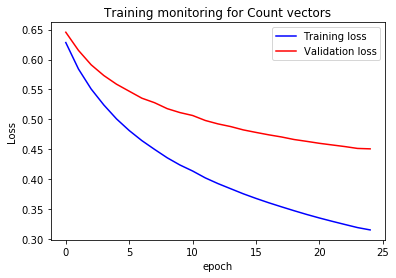

In [30]:
# plot the training and validation history per epoch

plot_model_loss(loss_tr_count, dev_loss_count, model = 'Count vectors')

**Analyis:**

From the plot we can see, that the validation learning curve is above training and is decreasing over the whole region. <br>So for the current state, I would say that it is the case of about right with tiny underfitting when more model's training is needed until learning curves reach their more stable and explicit minimum.

### Model's Evaluation

In [31]:
# Compute accuracy, precision, recall and F1-scores:
preds_te_count = predict_class(X_test_count, w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.83
Precision: 0.84375
Recall: 0.81
F1-Score: 0.826530612244898


In [32]:
# print the top-10 words for the negative and positive class respectively

def print_top_word(weights, dict_id_word = dict_id_word, class_interest = "positive", topN_words=10, just_words=True):
    
    # enumerate weigths so that further we can match a weight's index with the word it represents
    w_enumerated = list(enumerate(weights))
    
    if class_interest == "positive":
        # for positive class we take the weights with the highest positive value
        w_enumerated.sort(key = lambda x: x[1], reverse=True)
        topN_weights = w_enumerated[:topN_words]
        # it can happen that there are no positive words that we specify by topN_words argument
        # but we want only positive, so we put a restriction that weight (x[1] in tuple pair)>0
        pos_weights = [x[1] for x in topN_weights if x[1]>0]
        top_words = [dict_id_word[x[0]] for x in topN_weights if x[1]>0]
        print("\nTop %i words for positive class:" %  len(top_words))
        if just_words:
            print(top_words)
        else:
            print(list(zip(top_words, pos_weights)))
    
    else:
        # for negative class we take the weights with the highest negative value
        w_enumerated.sort(key = lambda x: x[1], reverse=False)
        topN_weights = w_enumerated[:topN_words]
        # it can happen that there are no negative words that we specify by topN_words argument
        # but we want only negative, so we put a restriction that weight (x[1] in tuple pair)<0
        neg_weights = [x[1] for x in topN_weights if x[1]<0]
        top_words = [dict_id_word[x[0]] for x in topN_weights if x[1]<0]
        print("\nTop %i words for negative class:" %  len(top_words))
        if just_words:
            print(top_words)
        else:
            print(list(zip(top_words, neg_weights)))


In [33]:
print_top_word(w_count, class_interest = "positive", topN_words=10)
print_top_word(w_count, class_interest = "negative", topN_words=10)


Top 10 words for positive class:
['great', 'well', 'also', 'life', 'world', 'many', 'best', 'seen', 'see', 'very']

Top 10 words for negative class:
['bad', 'only', 'plot', 'why', 'even', 'any', 'worst', 'script', 'nothing', 'no']


## Train and Evaluate Logistic Regression with TF.IDF vectors


In [34]:
number_epochs = 100
tolerance=0.001
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, lr=0.0001, alpha=0.00001, tolerance=tolerance,
                         epochs=number_epochs)

Epoch 0: | Training loss: 0.581075, | Validation loss: 0.626324
Epoch 1: | Training loss: 0.512115, | Validation loss: 0.586725
Epoch 2: | Training loss: 0.463473, | Validation loss: 0.558237
Epoch 3: | Training loss: 0.426222, | Validation loss: 0.537377
Epoch 4: | Training loss: 0.396323, | Validation loss: 0.521003
Epoch 5: | Training loss: 0.371482, | Validation loss: 0.507239
Epoch 6: | Training loss: 0.350533, | Validation loss: 0.495834
Epoch 7: | Training loss: 0.332326, | Validation loss: 0.485968
Epoch 8: | Training loss: 0.316095, | Validation loss: 0.477254
Epoch 9: | Training loss: 0.302034, | Validation loss: 0.469677
Epoch 10: | Training loss: 0.289384, | Validation loss: 0.462953
Epoch 11: | Training loss: 0.277450, | Validation loss: 0.456777
Epoch 12: | Training loss: 0.266903, | Validation loss: 0.451192
Epoch 13: | Training loss: 0.257334, | Validation loss: 0.446069
Epoch 14: | Training loss: 0.248364, | Validation loss: 0.441786
Epoch 15: | Training loss: 0.240113

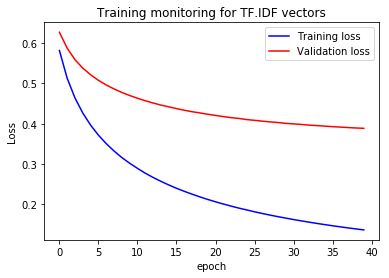

In [35]:
# plot the training and validation history per epoch
plot_model_loss(trl, devl, model = 'TF.IDF vectors')

**Analysis:**

At the current plot, we can see validation curve going to a plato region, while the training curve continues to decrease. <br> Together with a significant difference between final values of training and validation losses, this points to ovefitting. However, validation curve didn't start to increase after its decrease, so we can guess that a rather small regularisation will be needed.

### Model's Evaluation

In [36]:
# Compute accuracy, precision, recall and F1-scores
preds_te = predict_class(X_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.8675
Precision: 0.8620689655172413
Recall: 0.875
F1-Score: 0.8684863523573201


In [37]:
# print top-10 most positive and negative words for tf.idf vectors scheme:
print("TF.IDF vectors:")
print_top_word(w_tfidf, class_interest = "positive", topN_words=20)
print_top_word(w_tfidf, class_interest = "negative", topN_words=20)

TF.IDF vectors:

Top 20 words for positive class:
['great', 'well', 'also', 'life', 'fun', 'seen', 'truman', 'very', 'many', 'perfectly', 'hilarious', 'world', 'quite', 'both', 'movies', 'see', 'perfect', 'terrific', 'pulp', 'memorable']

Top 20 words for negative class:
['bad', 'worst', 'boring', 'plot', 'only', 'unfortunately', 'why', 'supposed', 'script', 'nothing', 'even', 'any', 'there', 'looks', 'so', 'harry', 'ridiculous', 'least', 'waste', 'stupid']


In [38]:
# rint top-10 most positive and negative words for count vectors scheme:
print("Count vectors:")
print_top_word(w_count, class_interest = "positive", topN_words=20)
print_top_word(w_count, class_interest = "negative", topN_words=20)

Count vectors:

Top 20 words for positive class:
['great', 'well', 'also', 'life', 'world', 'many', 'best', 'seen', 'see', 'very', 'both', 'most', 'movies', 'way', 'quite', 'fun', 'american', 'good', 'true', 'war']

Top 20 words for negative class:
['bad', 'only', 'plot', 'why', 'even', 'any', 'worst', 'script', 'nothing', 'no', 'unfortunately', 'boring', 'there', 'so', 'director', 'least', 'supposed', 'better', 'looks', 'then']


### Choosing model hyperparameters

In [39]:
def check_ngram(X_tr_raw, X_dev_raw, X_test_raw, ngram_range=(1,3), vector_scheme = "count", capitalisation = True):
    """ Function to unite all previous models - data preprocesing with parameters to choose:
        ngram_range - default (1,3), 
        capitalisation - default = True,
        vector_scheme - count or tfidf
        """
    
    vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=ngram_range, keep_topN=5000, stop_words=stop_words, capitalisation = True)
    X_ngram_tr = [extract_ngrams(x, ngram_range=ngram_range, stop_words=stop_words, vocab=vocab, capitalisation = capitalisation) for x in X_tr_raw]
    X_ngram_dev = [extract_ngrams(x, ngram_range=ngram_range, stop_words=stop_words, vocab=vocab, capitalisation = capitalisation) for x in X_dev_raw]
    X_ngram_test = [extract_ngrams(x, ngram_range=ngram_range, stop_words=stop_words, vocab=vocab, capitalisation = capitalisation) for x in X_test_raw]
    
    dict_id_word = dict(enumerate(vocab))
    dict_word_id = {value:key for (key, value) in dict_id_word.items()}
    
    # vectorisation
    X_train = vectorise(X_ngram_tr, vocab, dict_word_id)
    X_dev = vectorise(X_ngram_dev, vocab, dict_word_id)
    X_test = vectorise(X_ngram_test, vocab, dict_word_id)
    if vector_scheme == "tfidf":
        vocab_df = np.array([df[word] for word in vocab])
        idf = np.log10(len(vocab)/vocab_df)
        X_train = X_train*idf
        X_dev = X_dev*idf
        X_test = X_test*idf
    
    return X_train, X_dev, X_test, dict_id_word


def test_parameters(X_train, X_dev, Y_train, Y_dev, tolerance, reg_alpha, learning_rate, number_epochs=100,
                    vector_scheme = "count", print_top_words = True, print_progress= False):
    
    w, loss_train, loss_dev = SGD(X_train, Y_train, X_dev=X_dev, Y_dev=Y_dev, lr=learning_rate, alpha=reg_alpha, 
                                  epochs=number_epochs, tolerance=tolerance, print_progress= False)
#     print(w[:5])
    plot_model_loss(loss_train, loss_dev, model = vector_scheme + ' vectors', scale_y = True, 
                    ylim=(0, 0.5), print_last_values=True)
    
    preds = predict_class(X_dev, w)
    accuracy_score_0 = accuracy_score(Y_dev, preds)
    precision_score_0 = precision_score(Y_dev, preds)
    recall_score_0 = recall_score(Y_dev, preds)
    f1_score_0 = f1_score(Y_dev, preds)
    print('Accuracy:', accuracy_score_0)
    print('Precision:', precision_score_0 )
    print('Recall:', recall_score_0)
    print('F1-Score:', f1_score_0)

    if print_top_words:
        print("\n%s vectors:" % vector_scheme)
        print_top_word(w, class_interest = "positive", topN_words=10, just_words=False)
        print_top_word(w, class_interest = "negative", topN_words=10, just_words=False)
        
    return w, accuracy_score_0, precision_score_0, recall_score_0, f1_score_0

### BOW-count

Number of all ngrams for term frequency calculation:  1742589
Number of all sets of ngrams for doc frequency calculation:  1559784

------------------------------
Regularisation is: 0
Convergence at epoch 24 for tolerance = 0.001000 has been reached


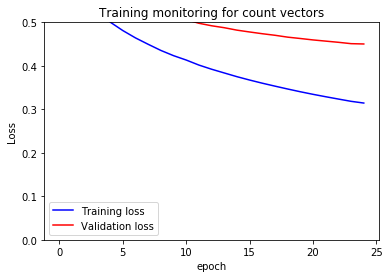


Training loss: [0.3289536727117721, 0.32362928786087924, 0.3184116149759836, 0.31445835988792764]
Validation loss: [0.4568531777322022, 0.4541428176945874, 0.4510132315363808, 0.4502928566415676]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Regularisation is: 0.0001
Convergence at epoch 24 for tolerance = 0.001000 has been reached


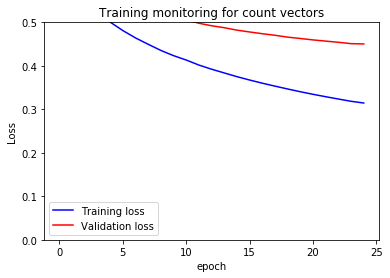


Training loss: [0.32900434378208004, 0.32368233821952136, 0.318467211700073, 0.3145166266194321]
Validation loss: [0.4568816538487578, 0.454172217988709, 0.45104349383759407, 0.4503250227427236]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Regularisation is: 0.001
Convergence at epoch 24 for tolerance = 0.001000 has been reached


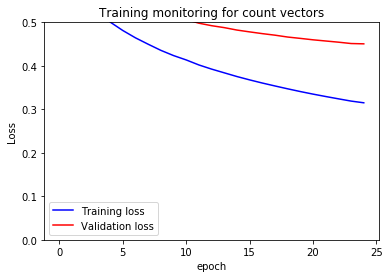


Training loss: [0.32946005628489333, 0.3241594379234656, 0.3189672038453036, 0.3150406179704128]
Validation loss: [0.45713786997021416, 0.45443675077011114, 0.4513157951267223, 0.45061445766475267]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Regularisation is: 0.01
Convergence at epoch 24 for tolerance = 0.001000 has been reached


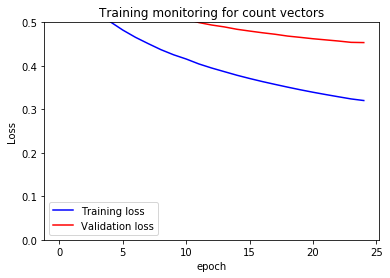


Training loss: [0.33398432787049004, 0.32889489055704535, 0.32392902023491776, 0.32023927378063805]
Validation loss: [0.4596925159096309, 0.4570743652891642, 0.45403197760700936, 0.45350174899088713]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Regularisation is: 0.1
Convergence at epoch 34 for tolerance = 0.001000 has been reached


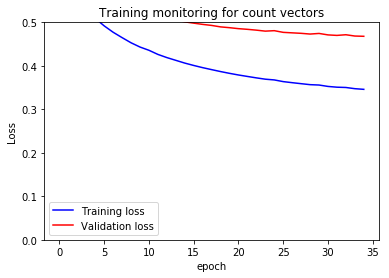


Training loss: [0.3509278014874155, 0.3502646737998755, 0.34749994036001947, 0.3459809189557463]
Validation loss: [0.47000927442385226, 0.4715272205678558, 0.4685493044869788, 0.4679443604747413]
Accuracy: 0.84
Precision: 0.8333333333333334
Recall: 0.85
F1-Score: 0.8415841584158417

------------------------------
Regularisation is: 0.5
Convergence at epoch 13 for tolerance = 0.001000 has been reached


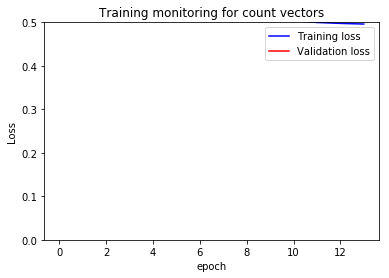


Training loss: [0.5046867765691199, 0.49973590020466074, 0.49761930519076375, 0.49614485456715945]
Validation loss: [0.5658578502001483, 0.5605384229130106, 0.559372672585909, 0.5587995861184709]
Accuracy: 0.79
Precision: 0.8222222222222222
Recall: 0.74
F1-Score: 0.7789473684210526

------------------------------
Regularisation is: 1
Convergence at epoch 7 for tolerance = 0.001000 has been reached


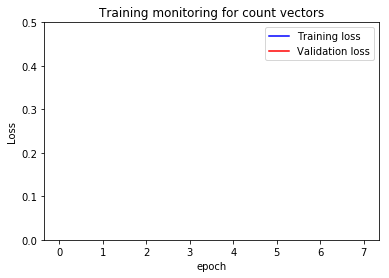


Training loss: [0.5675220794169081, 0.5621968600374125, 0.5586543662701435, 0.5567566463769413]
Validation loss: [0.6035361054460489, 0.6012540314758757, 0.5977991478815907, 0.5984077867182354]
Accuracy: 0.77
Precision: 0.8
Recall: 0.72
F1-Score: 0.7578947368421052
           Precision Recall        F1
reg_0.1     0.833333   0.85  0.841584
reg_0       0.831683   0.84  0.835821
reg_0.0001  0.831683   0.84  0.835821
reg_0.001   0.831683   0.84  0.835821
reg_0.01    0.831683   0.84  0.835821
reg_0.5     0.822222   0.74  0.778947
reg_1            0.8   0.72  0.757895

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 66 for tolerance = 0.001000 has been reached


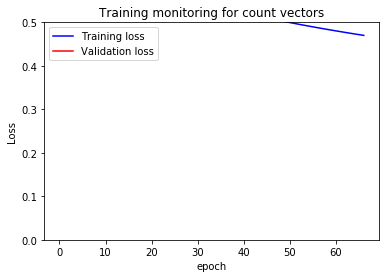


Training loss: [0.4750991445943662, 0.4733945087343297, 0.471716826514077, 0.4700473882276327]
Validation loss: [0.5424289018547419, 0.5413294126943665, 0.5402159956833313, 0.5392256262503039]
Accuracy: 0.795
Precision: 0.7864077669902912
Recall: 0.81
F1-Score: 0.7980295566502462

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 24 for tolerance = 0.001000 has been reached


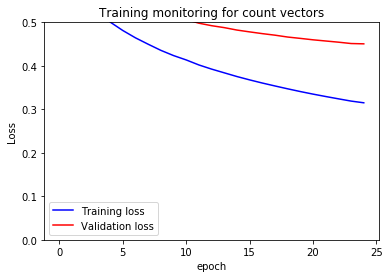


Training loss: [0.32946005628489333, 0.3241594379234656, 0.3189672038453036, 0.3150406179704128]
Validation loss: [0.45713786997021416, 0.45443675077011114, 0.4513157951267223, 0.45061445766475267]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Learning_rate is: 0.001
Convergence at epoch 9 for tolerance = 0.001000 has been reached


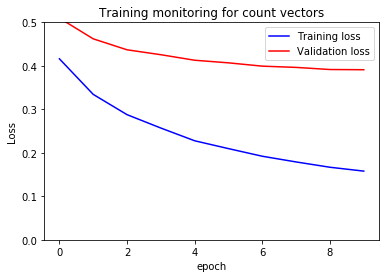


Training loss: [0.1921261851280771, 0.17901168953596355, 0.16681903399209122, 0.15794760693022217]
Validation loss: [0.3992939201126772, 0.396428063644506, 0.3915699399815338, 0.3910763755887022]
Accuracy: 0.825
Precision: 0.8217821782178217
Recall: 0.83
F1-Score: 0.8258706467661692

------------------------------
Learning_rate is: 0.002
Convergence at epoch 8 for tolerance = 0.001000 has been reached


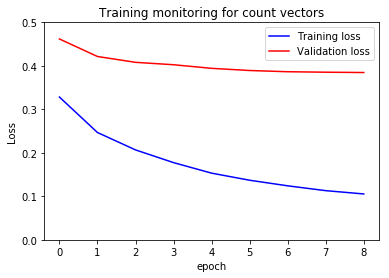


Training loss: [0.13697004696111534, 0.1241250529552422, 0.11301257407091778, 0.10543049680472226]
Validation loss: [0.38927651858558776, 0.3864862618282759, 0.3853893146057538, 0.38463915057571213]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Learning_rate is: 0.005
Convergence at epoch 8 for tolerance = 0.001000 has been reached


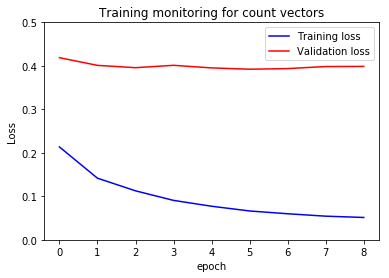


Training loss: [0.06629220330820201, 0.059885306081440846, 0.05433127984423376, 0.051347524210401334]
Validation loss: [0.3922601249304474, 0.3937215894336071, 0.3984295232101394, 0.3987309869958559]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388
          Precision Recall        F1
lr_0.0001  0.831683   0.84  0.835821
lr_0.002   0.831683   0.84  0.835821
lr_0.005   0.831683   0.84  0.835821
lr_0.001   0.821782   0.83  0.825871
lr_1e-05   0.786408   0.81   0.79803

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 58 for tolerance = 0.001000 has been reached


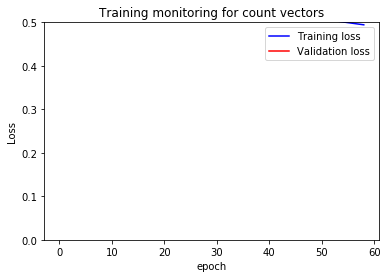


Training loss: [0.49933420794853184, 0.49764931546855906, 0.49599776383114097, 0.4943741263470871]
Validation loss: [0.5580711621513135, 0.5570619255661091, 0.5560365305657377, 0.5550606998118804]
Accuracy: 0.775
Precision: 0.7777777777777778
Recall: 0.77
F1-Score: 0.7738693467336684

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 34 for tolerance = 0.001000 has been reached


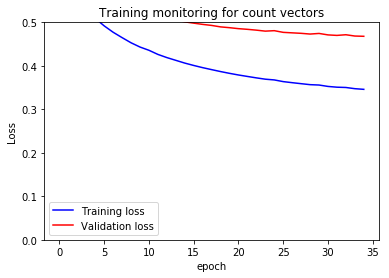


Training loss: [0.3509278014874155, 0.3502646737998755, 0.34749994036001947, 0.3459809189557463]
Validation loss: [0.47000927442385226, 0.4715272205678558, 0.4685493044869788, 0.4679443604747413]
Accuracy: 0.84
Precision: 0.8333333333333334
Recall: 0.85
F1-Score: 0.8415841584158417

------------------------------
Learning_rate is: 0.001
Convergence at epoch 19 for tolerance = 0.001000 has been reached


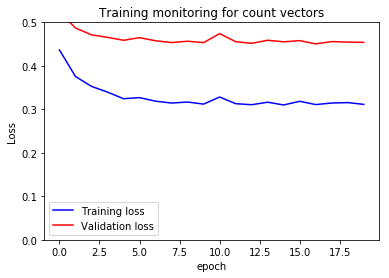


Training loss: [0.31095072002663177, 0.3145057196190433, 0.31549424613792854, 0.31136165031937996]
Validation loss: [0.45056111548219663, 0.45573916512949003, 0.45467190813075076, 0.4539367944655242]
Accuracy: 0.82
Precision: 0.8333333333333334
Recall: 0.8
F1-Score: 0.816326530612245

------------------------------
Learning_rate is: 0.002
Convergence at epoch 2 for tolerance = 0.001000 has been reached


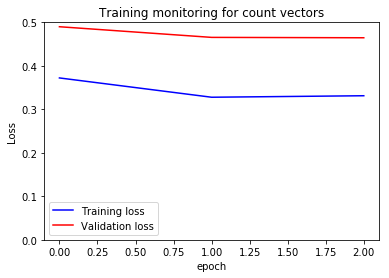


Training loss: [0.3721993127892627, 0.3278234107750729, 0.3312662908434573]
Validation loss: [0.48993880211770346, 0.46545869529870465, 0.46457893128753747]
Accuracy: 0.825
Precision: 0.76
Recall: 0.95
F1-Score: 0.8444444444444444

------------------------------
Learning_rate is: 0.005


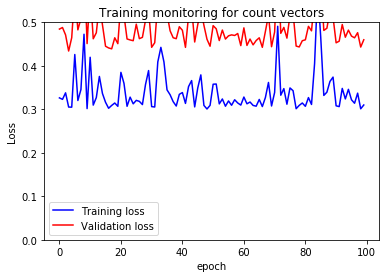


Training loss: [0.3139938518528519, 0.33719687435348733, 0.30123870054070195, 0.3099753545027263]
Validation loss: [0.4644589053076285, 0.47628421682330513, 0.44320382921653056, 0.4599988627584265]
Accuracy: 0.81
Precision: 0.8297872340425532
Recall: 0.78
F1-Score: 0.8041237113402062
          Precision Recall        F1
lr_0.002       0.76   0.95  0.844444
lr_0.0001  0.833333   0.85  0.841584
lr_0.001   0.833333    0.8  0.816327
lr_0.005   0.829787   0.78  0.804124
lr_1e-05   0.777778   0.77  0.773869

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 66 for tolerance = 0.001000 has been reached


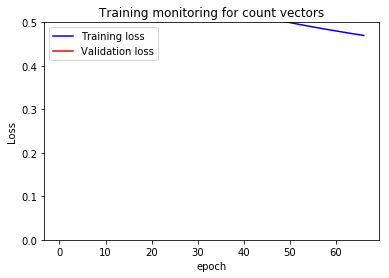


Training loss: [0.47497893998819596, 0.4732719177779289, 0.4715918392904481, 0.4699200083988496]
Validation loss: [0.5423493047067218, 0.5412483329218071, 0.5401335024625771, 0.5391416346078404]
Accuracy: 0.795
Precision: 0.7864077669902912
Recall: 0.81
F1-Score: 0.7980295566502462

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 24 for tolerance = 0.001000 has been reached


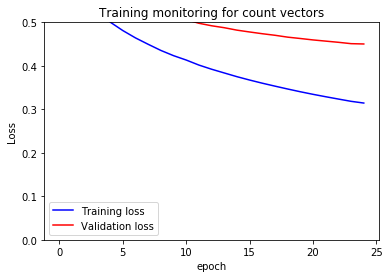


Training loss: [0.3289536727117721, 0.32362928786087924, 0.3184116149759836, 0.31445835988792764]
Validation loss: [0.4568531777322022, 0.4541428176945874, 0.4510132315363808, 0.4502928566415676]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Learning_rate is: 0.001
Convergence at epoch 9 for tolerance = 0.001000 has been reached


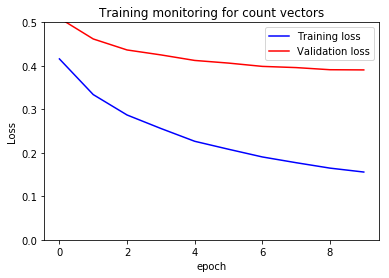


Training loss: [0.19052146861838037, 0.17727943006487082, 0.16483045196716772, 0.1558064289520396]
Validation loss: [0.3987659358938991, 0.39598829154466636, 0.39109081756348274, 0.39065684232337217]
Accuracy: 0.825
Precision: 0.8217821782178217
Recall: 0.83
F1-Score: 0.8258706467661692

------------------------------
Learning_rate is: 0.002
Convergence at epoch 7 for tolerance = 0.001000 has been reached


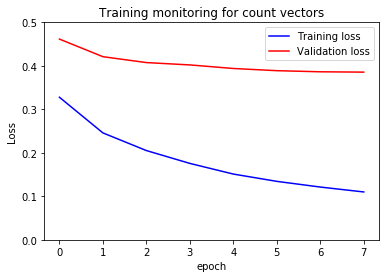


Training loss: [0.15115486323296864, 0.1343824387766082, 0.12128252163560885, 0.11000767402416545]
Validation loss: [0.3939354244277562, 0.38889757144308545, 0.38633249613759785, 0.38556127437559296]
Accuracy: 0.83
Precision: 0.8235294117647058
Recall: 0.84
F1-Score: 0.8316831683168315

------------------------------
Learning_rate is: 0.005
Convergence at epoch 9 for tolerance = 0.001000 has been reached


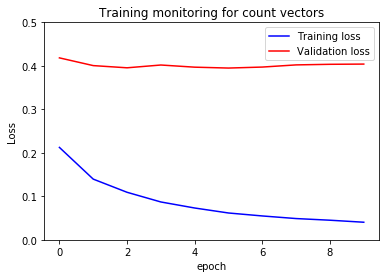


Training loss: [0.054834509832913464, 0.048838962675740845, 0.04503121904403981, 0.04038946108282528]
Validation loss: [0.3972074288812503, 0.4021902624125573, 0.4035483576732548, 0.40405691524600956]
Accuracy: 0.845
Precision: 0.8285714285714286
Recall: 0.87
F1-Score: 0.848780487804878
          Precision Recall        F1
lr_0.005   0.828571   0.87   0.84878
lr_0.0001  0.831683   0.84  0.835821
lr_0.002   0.823529   0.84  0.831683
lr_0.001   0.821782   0.83  0.825871
lr_1e-05   0.786408   0.81   0.79803

------------------------------
Learning_rate is: 1e-05


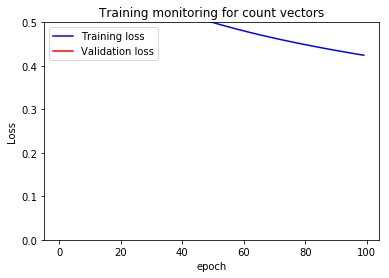


Training loss: [0.427956494121619, 0.4267625097622895, 0.4255792943611804, 0.4244077879698591]
Validation loss: [0.5132834324170203, 0.5125073907858314, 0.5117986920237864, 0.5111401978335808]
Accuracy: 0.805
Precision: 0.7961165048543689
Recall: 0.82
F1-Score: 0.8078817733990147

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 84 for tolerance = 0.000100 has been reached


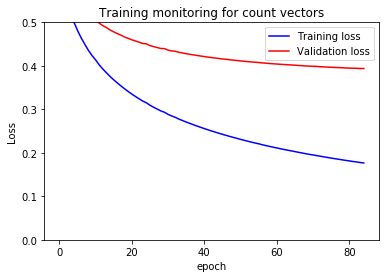


Training loss: [0.18012050960458142, 0.1790095711927921, 0.1777095241253808, 0.17673003051613875]
Validation loss: [0.39450980218923093, 0.3943080962918198, 0.39388437352644273, 0.39393334033881283]
Accuracy: 0.845
Precision: 0.8285714285714286
Recall: 0.87
F1-Score: 0.848780487804878

------------------------------
Learning_rate is: 0.001
Convergence at epoch 13 for tolerance = 0.000100 has been reached


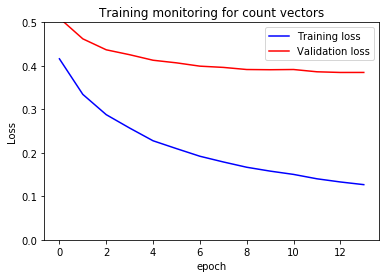


Training loss: [0.15036784143040655, 0.1402821605813046, 0.13297851031177688, 0.12682318765411646]
Validation loss: [0.39157565442803366, 0.3863477924833956, 0.38479718116938544, 0.38483303663635526]
Accuracy: 0.845
Precision: 0.822429906542056
Recall: 0.88
F1-Score: 0.8502415458937198

------------------------------
Learning_rate is: 0.002
Convergence at epoch 17 for tolerance = 0.000100 has been reached


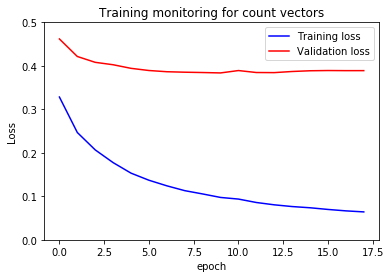


Training loss: [0.07366051994502154, 0.06980348059398857, 0.06653733742776555, 0.06415253931494991]
Validation loss: [0.38869757533005517, 0.3892210779955342, 0.38897095501326584, 0.38898957277608526]
Accuracy: 0.835
Precision: 0.8316831683168316
Recall: 0.84
F1-Score: 0.835820895522388

------------------------------
Learning_rate is: 0.005
Convergence at epoch 17 for tolerance = 0.000100 has been reached


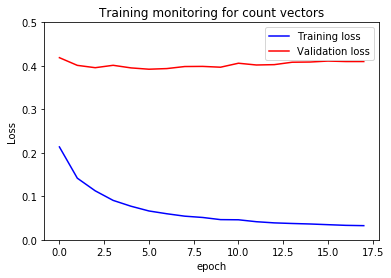


Training loss: [0.03636858882336356, 0.034769938152526776, 0.033226638013987474, 0.03253621885862212]
Validation loss: [0.40878752529566786, 0.4110421241673731, 0.40990595884557324, 0.40989881963306807]
Accuracy: 0.84
Precision: 0.8333333333333334
Recall: 0.85
F1-Score: 0.8415841584158417
          Precision Recall        F1
lr_0.001    0.82243   0.88  0.850242
lr_0.0001  0.828571   0.87   0.84878
lr_0.005   0.833333   0.85  0.841584
lr_0.002   0.831683   0.84  0.835821
lr_1e-05   0.796117   0.82  0.807882
CPU times: user 2min 15s, sys: 3.44 s, total: 2min 19s
Wall time: 1min 17s


In [40]:
%%time
vector_scheme = "count"
X_train_vect, X_dev_vect, X_test_vect, dict_id_word = check_ngram(X_tr_raw, X_dev_raw, X_test_raw, 
                ngram_range=(1,3), vector_scheme = vector_scheme, capitalisation = False)

# !!! testing hyperparameters on validation set !!!
learing_rate_to_test = [0.00001, 0.0001, 0.001, 0.002, 0.005]
regularisation_to_test = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
lr_columns= ["lr_"+str(i) for i in learing_rate_to_test]
reg_columns = ["reg_"+str(i) for i in regularisation_to_test]


# 1. Test different regularisation strength for default learning rate

parameter_tested = "Regularisation"
number_epochs = 200
tolerance=0.001
lr=0.0001
# alpha=0.001

accuracies = []
precisions = []
recalls = []
f1s = []

for alpha in regularisation_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", alpha)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev, tolerance = tolerance,
            reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count", print_top_words = False,
            print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = reg_columns, columns = ["Precision", "Recall", "F1"])
results.loc[reg_columns, "Precision"] = precisions
results.loc[reg_columns, "Recall"] = recalls
results.loc[reg_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

#2. Testing learning rate for default reg_0.001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0.001

accuracies = []
precisions = []
recalls = []
f1s = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev, tolerance = tolerance, 
            reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count", print_top_words = False,
            print_progress= False)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1"])
results.loc[lr_columns, "Precision"] = precisions
results.loc[lr_columns, "Recall"] = recalls
results.loc[lr_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

#3. Testing learning rate for best_founf reg_0.1
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0.1

accuracies = []
precisions = []
recalls = []
f1s = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev, tolerance = tolerance,
            reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count", print_top_words = False,
            print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1"])
results.loc[lr_columns, "Precision"] = precisions
results.loc[lr_columns, "Recall"] = recalls
results.loc[lr_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

# 4. Testing learning rate for reg_0
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0

accuracies = []
precisions = []
recalls = []
f1s = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev, tolerance = tolerance,
             reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count", print_top_words = False, 
             print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1"])
results.loc[lr_columns, "Precision"] = precisions
results.loc[lr_columns, "Recall"] = recalls
results.loc[lr_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

#5. Testing learning rate for reg_0.001 and other tolerance=0.0001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.0001
# lr=0.0001
alpha=0.001

accuracies = []
precisions = []
recalls = []
f1s = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev, tolerance = tolerance, 
            reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count", print_top_words = False, 
            print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1"])
results.loc[lr_columns, "Precision"] = precisions
results.loc[lr_columns, "Recall"] = recalls
results.loc[lr_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

Best parameters for Bow-Count found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8316  | 0.84  | 0.8358 |
| !!! best_found: tol = 0.001,reg = 0.1, lr=0.0001|  0.8333| 0.85  |  0.8415 |
| other_found: tol = 0.001, reg_0, lr=0.005|  0.8286| 0.87  |  0.8488 |
| others: tol=0.0001, reg = 0.001, lr=0.001|  0.8224| 0.88  |  0.8502 |
| others: tol=0.0001, reg = 0.1, lr=0.0001|  0.8333| 0.85  |  0.8415|

### BOW-tfidf

Number of all ngrams for term frequency calculation:  1742589
Number of all sets of ngrams for doc frequency calculation:  1559784

------------------------------
Regularisation is: 0
Convergence at epoch 39 for tolerance = 0.001000 has been reached


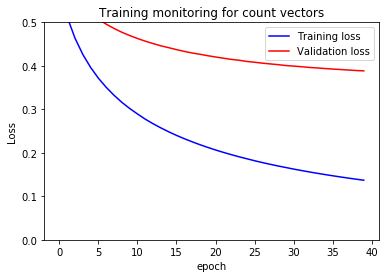


Training loss: [0.14456216809114694, 0.14194331675265906, 0.13941911618932334, 0.13698796279801062]
Validation loss: [0.3915793276260869, 0.3903760785225158, 0.38930398931881127, 0.38850735560262634]
Accuracy: 0.85
Precision: 0.8431372549019608
Recall: 0.86
F1-Score: 0.8514851485148515

------------------------------
Regularisation is: 1e-05
Convergence at epoch 39 for tolerance = 0.001000 has been reached


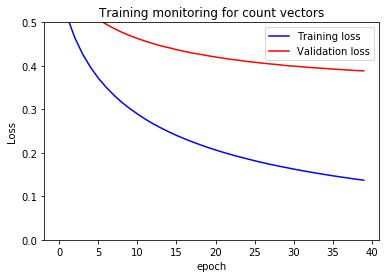


Training loss: [0.14457068882932442, 0.14195201261633594, 0.13942798400982093, 0.1369970014379323]
Validation loss: [0.39158302073871004, 0.3903798028137264, 0.3893077537854536, 0.38851115563350413]
Accuracy: 0.85
Precision: 0.8431372549019608
Recall: 0.86
F1-Score: 0.8514851485148515

------------------------------
Regularisation is: 0.0001
Convergence at epoch 39 for tolerance = 0.001000 has been reached


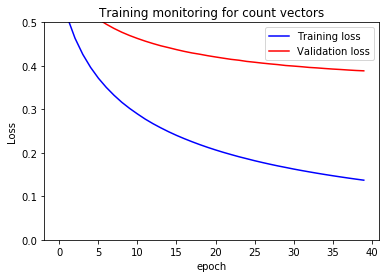


Training loss: [0.14464737336003208, 0.14203027337202473, 0.13950779247202286, 0.13707834739368335]
Validation loss: [0.39161626471062083, 0.39041332809738677, 0.3893416413302681, 0.388545363854824]
Accuracy: 0.85
Precision: 0.8431372549019608
Recall: 0.86
F1-Score: 0.8514851485148515

------------------------------
Regularisation is: 0.001
Convergence at epoch 39 for tolerance = 0.001000 has been reached


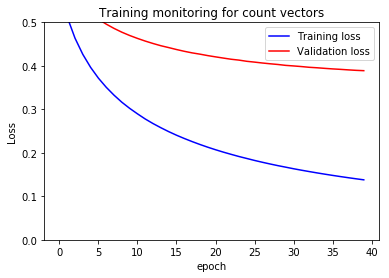


Training loss: [0.14541400409745614, 0.14281267532063666, 0.1403056803770273, 0.13789162142954262]
Validation loss: [0.39194928723927314, 0.3907492327785135, 0.38968123536518895, 0.38888822310083926]
Accuracy: 0.85
Precision: 0.8431372549019608
Recall: 0.86
F1-Score: 0.8514851485148515

------------------------------
Regularisation is: 0.01
Convergence at epoch 36 for tolerance = 0.001000 has been reached


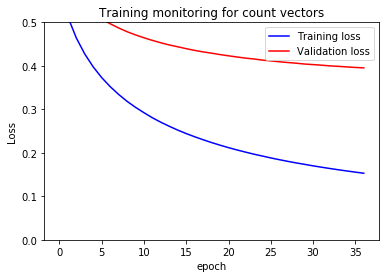


Training loss: [0.16101311010294778, 0.15825005387611793, 0.15560208226768757, 0.15305364506212987]
Validation loss: [0.3988456905356596, 0.3975156847604112, 0.3963066291862142, 0.3953310060611945]
Accuracy: 0.85
Precision: 0.8431372549019608
Recall: 0.86
F1-Score: 0.8514851485148515

------------------------------
Regularisation is: 0.1
Convergence at epoch 28 for tolerance = 0.001000 has been reached


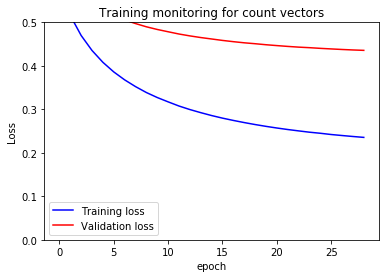


Training loss: [0.24210347349476413, 0.2397826019631922, 0.23755439548278418, 0.23548876921548464]
Validation loss: [0.438913432836198, 0.43764185618488805, 0.4365432960566451, 0.43561927755853097]
Accuracy: 0.845
Precision: 0.8285714285714286
Recall: 0.87
F1-Score: 0.848780487804878

------------------------------
Regularisation is: 0.5
Convergence at epoch 10 for tolerance = 0.001000 has been reached


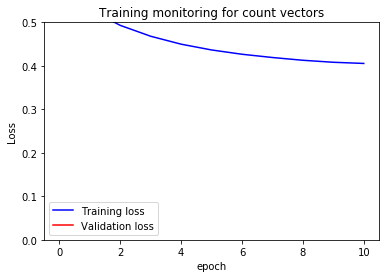


Training loss: [0.41917070867479644, 0.4128119229694, 0.40822427814684226, 0.4055354737314602]
Validation loss: [0.5352739260120817, 0.5314127380808235, 0.5291790604375628, 0.5283189529363298]
Accuracy: 0.825
Precision: 0.8350515463917526
Recall: 0.81
F1-Score: 0.8223350253807107

------------------------------
Regularisation is: 1
Convergence at epoch 7 for tolerance = 0.001000 has been reached


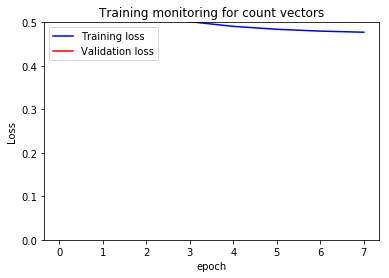


Training loss: [0.4907360670301378, 0.4840861093410875, 0.47987817061609833, 0.47732030853498925]
Validation loss: [0.5753186902885191, 0.5716359845270902, 0.5687551586188616, 0.5684385288247072]
Accuracy: 0.825
Precision: 0.8350515463917526
Recall: 0.81
F1-Score: 0.8223350253807107
           Precision Recall        F1
reg_0       0.843137   0.86  0.851485
reg_1e-05   0.843137   0.86  0.851485
reg_0.0001  0.843137   0.86  0.851485
reg_0.001   0.843137   0.86  0.851485
reg_0.01    0.843137   0.86  0.851485
reg_0.1     0.828571   0.87   0.84878
reg_0.5     0.835052   0.81  0.822335
reg_1       0.835052   0.81  0.822335

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 74 for tolerance = 0.001000 has been reached


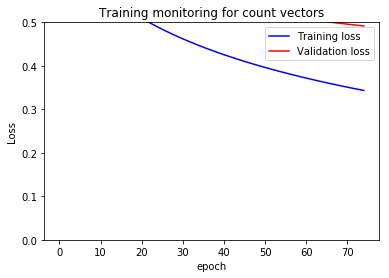


Training loss: [0.34905805433438464, 0.3471609623009946, 0.34528927209525023, 0.3434436090674702]
Validation loss: [0.49483368081867807, 0.4938089316692386, 0.4927955716686683, 0.49179979693133336]
Accuracy: 0.82
Precision: 0.8018867924528302
Recall: 0.85
F1-Score: 0.8252427184466019

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 39 for tolerance = 0.001000 has been reached


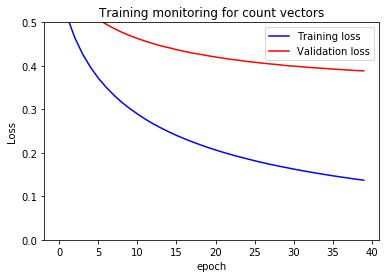


Training loss: [0.14457068882932442, 0.14195201261633594, 0.13942798400982093, 0.1369970014379323]
Validation loss: [0.39158302073871004, 0.3903798028137264, 0.3893077537854536, 0.38851115563350413]
Accuracy: 0.85
Precision: 0.8431372549019608
Recall: 0.86
F1-Score: 0.8514851485148515

------------------------------
Learning_rate is: 0.001
Convergence at epoch 10 for tolerance = 0.001000 has been reached


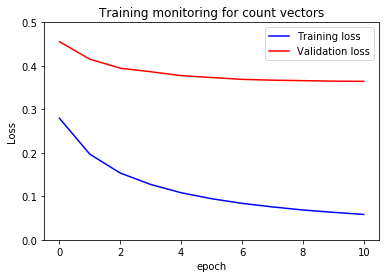


Training loss: [0.07563218365837683, 0.06852641829813154, 0.06319233950448452, 0.058327953044817214]
Validation loss: [0.36702358342493435, 0.36595546216421504, 0.3647983627018374, 0.36433871399170853]
Accuracy: 0.855
Precision: 0.8514851485148515
Recall: 0.86
F1-Score: 0.8557213930348259

------------------------------
Learning_rate is: 0.002
Convergence at epoch 3 for tolerance = 0.001000 has been reached


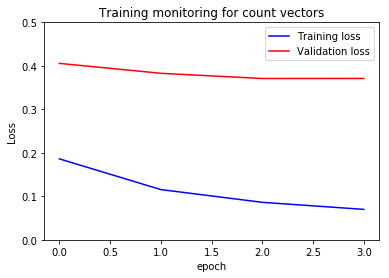


Training loss: [0.18609102321887985, 0.11548200561795005, 0.08616220579015943, 0.06997422579320507]
Validation loss: [0.40568010749504096, 0.3828494447879255, 0.3709223483910031, 0.37104899504349814]
Accuracy: 0.86
Precision: 0.8272727272727273
Recall: 0.91
F1-Score: 0.8666666666666667

------------------------------
Learning_rate is: 0.005


/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Convergence at epoch 5 for tolerance = 0.001000 has been reached


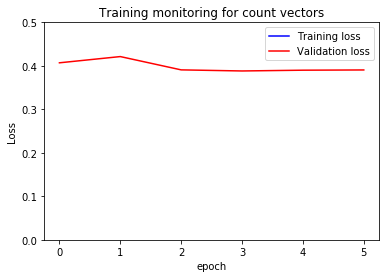


Training loss: [nan, nan, nan, nan]
Validation loss: [0.39074514734109017, 0.38823582024746783, 0.39000153993868564, 0.390562583304661]
Accuracy: 0.865
Precision: 0.8543689320388349
Recall: 0.88
F1-Score: 0.8669950738916256
          Precision Recall        F1
lr_0.005   0.854369   0.88  0.866995
lr_0.002   0.827273   0.91  0.866667
lr_0.001   0.851485   0.86  0.855721
lr_0.0001  0.843137   0.86  0.851485
lr_1e-05   0.801887   0.85  0.825243

------------------------------
Regularisation is: 0


/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Convergence at epoch 5 for tolerance = 0.001000 has been reached


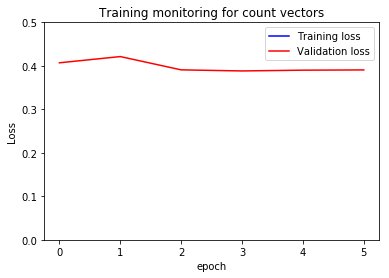


Training loss: [nan, nan, nan, nan]
Validation loss: [0.3907824722258368, 0.3882828387442751, 0.3900614771711641, 0.3906361812884284]
Accuracy: 0.865
Precision: 0.8543689320388349
Recall: 0.88
F1-Score: 0.8669950738916256

------------------------------
Regularisation is: 1e-05
Convergence at epoch 5 for tolerance = 0.001000 has been reached


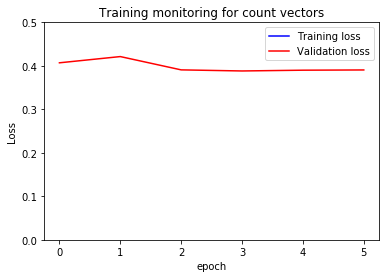


Training loss: [nan, nan, nan, nan]
Validation loss: [0.39074514734109017, 0.38823582024746783, 0.39000153993868564, 0.390562583304661]
Accuracy: 0.865
Precision: 0.8543689320388349
Recall: 0.88
F1-Score: 0.8669950738916256

------------------------------
Regularisation is: 0.0001
Convergence at epoch 5 for tolerance = 0.001000 has been reached


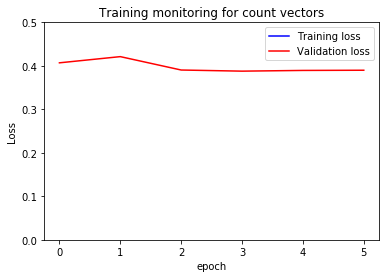


Training loss: [nan, nan, nan, nan]
Validation loss: [0.390410145975856, 0.38781560615079436, 0.3894669024758262, 0.38990692123954157]
Accuracy: 0.865
Precision: 0.8543689320388349
Recall: 0.88
F1-Score: 0.8669950738916256

------------------------------
Regularisation is: 0.001
Convergence at epoch 4 for tolerance = 0.001000 has been reached


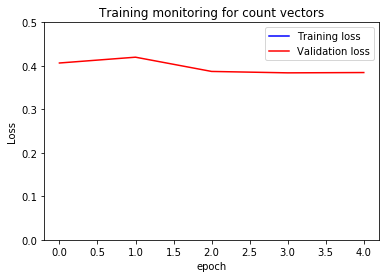


Training loss: [nan, nan, nan, nan]
Validation loss: [0.41989885758158424, 0.38715209792360383, 0.3839046074396269, 0.38459431788959797]
Accuracy: 0.85
Precision: 0.8571428571428571
Recall: 0.84
F1-Score: 0.8484848484848485

------------------------------
Regularisation is: 0.01
Convergence at epoch 4 for tolerance = 0.001000 has been reached


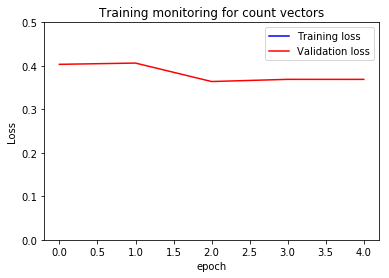


Training loss: [nan, nan, nan, nan]
Validation loss: [0.4063736419551895, 0.36393508584172474, 0.3689477757114896, 0.3688965515658793]
Accuracy: 0.86
Precision: 0.8529411764705882
Recall: 0.87
F1-Score: 0.8613861386138614

------------------------------
Regularisation is: 0.1
Convergence at epoch 87 for tolerance = 0.001000 has been reached


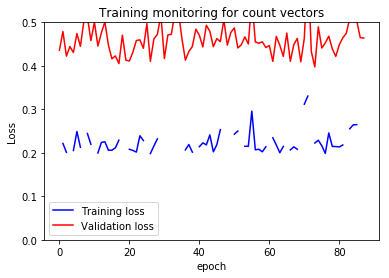


Training loss: [0.2643723987832913, 0.2648820303577545, nan, 0.2614814298497774]
Validation loss: [0.6118169788738292, 0.5029455880900935, 0.46466203543808904, 0.4639058491099943]
Accuracy: 0.81
Precision: 0.7980769230769231
Recall: 0.83
F1-Score: 0.8137254901960785

------------------------------
Regularisation is: 0.5
Convergence at epoch 44 for tolerance = 0.001000 has been reached


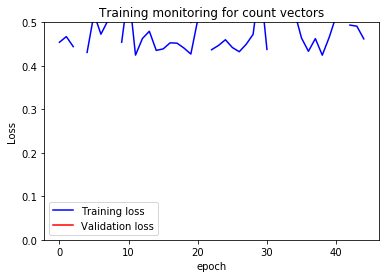


Training loss: [nan, 0.493747155641417, 0.4911746088707187, 0.462018347138358]
Validation loss: [0.5668723278244095, 0.6431720788382644, 0.6015582636836041, 0.6021347789122137]
Accuracy: 0.745
Precision: 0.6814814814814815
Recall: 0.92
F1-Score: 0.7829787234042553

------------------------------
Regularisation is: 1


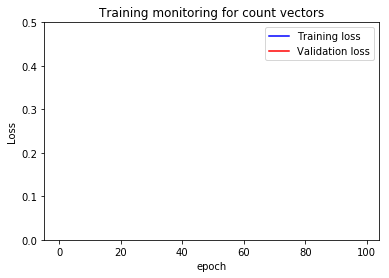


Training loss: [0.5332564284991406, 0.5144399365117652, 0.5102558147056346, 0.5271397699204589]
Validation loss: [0.606823558986097, 0.5872573212828442, 0.5705750923571322, 0.5775133852778856]
Accuracy: 0.74
Precision: 0.7033898305084746
Recall: 0.83
F1-Score: 0.7614678899082568
           Precision Recall        F1
reg_0       0.854369   0.88  0.866995
reg_1e-05   0.854369   0.88  0.866995
reg_0.0001  0.854369   0.88  0.866995
reg_0.01    0.852941   0.87  0.861386
reg_0.001   0.857143   0.84  0.848485
reg_0.1     0.798077   0.83  0.813725
reg_0.5     0.681481   0.92  0.782979
reg_1        0.70339   0.83  0.761468

------------------------------
Learning_rate is: 1e-05


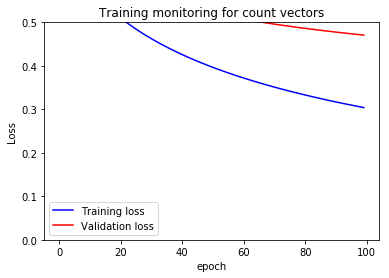


Training loss: [0.30822219035822856, 0.3068273440950516, 0.305447788099963, 0.30408317347916647]
Validation loss: [0.4729238937298389, 0.4721897212374649, 0.47145660102130876, 0.47072635155340975]
Accuracy: 0.83
Precision: 0.8173076923076923
Recall: 0.85
F1-Score: 0.8333333333333334

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 85 for tolerance = 0.000100 has been reached


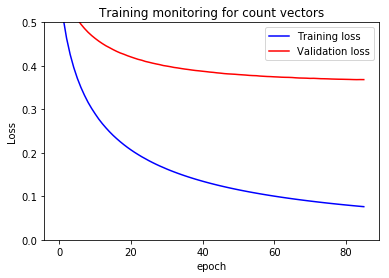


Training loss: [0.07846093170139465, 0.07768807671957384, 0.07692939213564698, 0.07618904656710898]
Validation loss: [0.36848035510554555, 0.36830777032058265, 0.3684500035022893, 0.368371187312828]
Accuracy: 0.86
Precision: 0.839622641509434
Recall: 0.89
F1-Score: 0.8640776699029127

------------------------------
Learning_rate is: 0.001
Convergence at epoch 12 for tolerance = 0.000100 has been reached


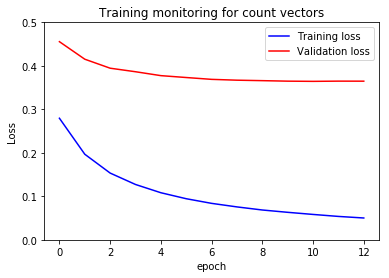


Training loss: [0.06319233950448452, 0.058327953044817214, 0.05375099489164396, 0.05015028225133711]
Validation loss: [0.3647983627018374, 0.36433871399170853, 0.3648513180691988, 0.36475926667897235]
Accuracy: 0.865
Precision: 0.8476190476190476
Recall: 0.89
F1-Score: 0.8682926829268293

------------------------------
Learning_rate is: 0.002
Convergence at epoch 5 for tolerance = 0.000100 has been reached


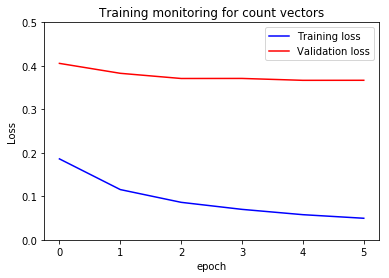


Training loss: [0.08616220579015943, 0.06997422579320507, 0.057759751565862265, 0.04952887658010398]
Validation loss: [0.3709223483910031, 0.37104899504349814, 0.366705758219544, 0.36679182249043246]
Accuracy: 0.875
Precision: 0.8571428571428571
Recall: 0.9
F1-Score: 0.8780487804878048

------------------------------
Learning_rate is: 0.005


/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


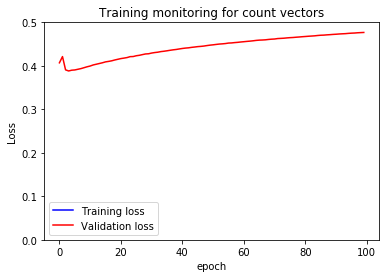


Training loss: [nan, nan, nan, nan]
Validation loss: [0.4754800653260214, 0.47605723127024663, 0.47643357527029606, 0.4767907518271198]
Accuracy: 0.855
Precision: 0.8514851485148515
Recall: 0.86
F1-Score: 0.8557213930348259
          Precision Recall        F1
lr_0.002   0.857143    0.9  0.878049
lr_0.001   0.847619   0.89  0.868293
lr_0.0001  0.839623   0.89  0.864078
lr_0.005   0.851485   0.86  0.855721
lr_1e-05   0.817308   0.85  0.833333
CPU times: user 2min 26s, sys: 3.59 s, total: 2min 29s
Wall time: 1min 20s


In [41]:
%%time
vector_scheme = "tfidf"
X_train_vect, X_dev_vect, X_test_vect, dict_id_word = check_ngram(X_tr_raw, X_dev_raw, X_test_raw, 
                    ngram_range=(1,3), vector_scheme = vector_scheme, capitalisation = False)

# !!! testing hyperparameters on validation set !!!
learing_rate_to_test = [0.00001, 0.0001, 0.001, 0.002, 0.005]
regularisation_to_test = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
lr_columns= ["lr_"+str(i) for i in learing_rate_to_test]
reg_columns = ["reg_"+str(i) for i in regularisation_to_test]


# 1. Test different regularisation strength for default learning rate

parameter_tested = "Regularisation"
number_epochs = 200
tolerance=0.001
lr=0.0001
# alpha=0.001

accuracies = []
precisions = []
recalls = []
f1s = []

for alpha in regularisation_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", alpha)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
               tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count",
               print_top_words = False, print_progress= False)
  
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = reg_columns, columns = ["Precision", "Recall", "F1"])
results.loc[reg_columns, "Precision"] = precisions
results.loc[reg_columns, "Recall"] = recalls
results.loc[reg_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))


#2. Testing learning rate for default reg_0.00001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0.00001

accuracies = []
precisions = []
recalls = []
f1s = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
               tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count",
               print_top_words = False, print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1"])
results.loc[lr_columns, "Precision"] = precisions
results.loc[lr_columns, "Recall"] = recalls
results.loc[lr_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

# 3. Test different regularisation strength for default learning rate

parameter_tested = "Regularisation"
number_epochs = 200
tolerance=0.001
lr=0.005
# alpha=0.001

accuracies = []
precisions = []
recalls = []
f1s = []

for alpha in regularisation_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", alpha)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
               tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count",
               print_top_words = False, print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = reg_columns, columns = ["Precision", "Recall", "F1"])
results.loc[reg_columns, "Precision"] = precisions
results.loc[reg_columns, "Recall"] = recalls
results.loc[reg_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))


#4. Testing learning rate for reg_0.00010 and other tolerance=0.0001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.0001
# lr=0.0001
alpha=0.00001

accuracies = []
precisions = []
recalls = []
f1s = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
               tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count",
               print_top_words = False, print_progress= False)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1"])
results.loc[lr_columns, "Precision"] = precisions
results.loc[lr_columns, "Recall"] = recalls
results.loc[lr_columns, "F1"] = f1s
print(results.sort_values("F1", ascending= False))

Best parameters for Bow-TF.IDF found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
|best_found == default: tol = 0.001, reg = 0.00001, lr=0.0001 | 0.8431  | 0.86  | 0.8514 |
|best_found == default: tol = 0.001, reg = 0, lr=0.0001 | 0.8431  | 0.86  | 0.8514 |
|!!! best_found: tol = 0.001, reg = 0.00001, lr=0.005 | 0.8543  | 0.88  | 0.8669 |
|best_found: tol = 0.001, reg = 0, lr=0.005 | 0.8543  | 0.88  | 0.8669 |
|other: tol = 0.0001, reg = 0.00001, lr=0.002 | 0.8571  | 0.90  | 0.878 |

Enter your answer here...
<br>As it can be seen from the previous comparison of model performance metrics (Precision, Recall and F1-Score) for validation set and the general shape of training and validation learning curves, the best parameters for both BOW-count and BOW-tfidf are: learning_rate = 0.001, regularisation_parameter_alpha = 0.005 

Answer 2:
<br>**What is the relation between training epochs and learning rate?**
<br>Answer: as it can be seen from our data, the number of training epochs required for convergence decreases with increase of learning rate. However, after a certain value (when learning rate starts to be too high for the current model), we can "jump" through the optimal minimum, so it the convergence cannot appear during further training.
<br>**How the regularisation strength affects performance?**
<br>Answer: In the begining, increasing of regularisation parameter slightly improves model performance, but then starts to do the opposite.

### Results for test set for the models with the best hyperparameters

Best parameters for Bow-Count found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8316  | 0.84  | 0.8358 |
| !!! best_found: tol = 0.001,reg = 0.1, lr=0.0001|  0.8333| 0.85  |  0.8415 |
| others: tol=0.0001, reg = 0.001, lr=0.001|  0.8224| 0.88  |  0.8502 |

In [42]:
# Default values
tolerance=0.001
learn_rate=0.0001
alpha = 0.001
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, X_dev=X_dev_count, Y_dev=Y_dev, 
                                             lr=learn_rate, alpha=alpha, epochs=number_epochs, 
                                             tolerance=tolerance, print_progress= False)
    
# fill in your code...
preds_te_count = predict_class(X_test_count, w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

#print top-words (the number in each tuple is a corresponding weight)
print("\n\nCount vectors:")
# print_top_word(w_count, class_interest = "positive", topN_words=10, just_words=False)
# print_top_word(w_count, class_interest = "negative", topN_words=10, just_words=False)
print_top_word(w_count, class_interest = "positive", topN_words=10, just_words=True)
print_top_word(w_count, class_interest = "negative", topN_words=10, just_words=True)

Convergence at epoch 24 for tolerance = 0.001000 has been reached
Accuracy: 0.83
Precision: 0.84375
Recall: 0.81
F1-Score: 0.826530612244898


Count vectors:

Top 10 words for positive class:
['great', 'well', 'also', 'life', 'world', 'many', 'best', 'seen', 'see', 'very']

Top 10 words for negative class:
['bad', 'only', 'plot', 'why', 'even', 'any', 'worst', 'script', 'nothing', 'no']


In [43]:
# Found best values: 
tolerance=0.001
learn_rate=0.001
alpha = 0.1
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, X_dev=X_dev_count, Y_dev=Y_dev, 
                                             lr=learn_rate, alpha=alpha, epochs=number_epochs, 
                                             tolerance=tolerance, print_progress= False)
    
# fill in your code...
preds_te_count = predict_class(X_test_count, w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

#print top-words (the number in each tuple is a corresponding weight)
print("\n\nCount vectors:")
# print_top_word(w_count, class_interest = "positive", topN_words=10, just_words=False)
# print_top_word(w_count, class_interest = "negative", topN_words=10, just_words=False)

print_top_word(w_count, class_interest = "positive", topN_words=10, just_words=True)
print_top_word(w_count, class_interest = "negative", topN_words=10, just_words=True)

Convergence at epoch 19 for tolerance = 0.001000 has been reached
Accuracy: 0.8325
Precision: 0.8518518518518519
Recall: 0.805
F1-Score: 0.8277634961439589


Count vectors:

Top 10 words for positive class:
['great', 'well', 'also', 'life', 'many', 'seen', 'world', 'fun', 'movies', 'both']

Top 10 words for negative class:
['bad', 'only', 'plot', 'why', 'worst', 'unfortunately', 'script', 'even', 'nothing', 'any']


Comparison of Bow-count on Validation Set

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8316  | 0.84  | 0.8358 |
| !!! best_found: tol = 0.001,reg = 0.1, lr=0.0001|  0.8333| 0.85  |  0.8415 |

Comparison of Bow-count on Test data   
    
| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8437  | 0.81  | 0.8265 |
| !!! best_found: tol = 0.001,reg = 0.1, lr=0.0001|  0.8518| 0.805  |  0.8277 |

So as it can be seen from the results, my hyperparameter tuning gave only a slight improvement in the final scores. But it is intersting to note that not only absolute values of weights for most significatn words changed, but also the words themselves!

In [44]:
# Default values
tolerance = 0.001
learn_rate = 0.0001
alpha = 0.00001
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr_tfidf, Y_tr, X_dev=X_dev_tfidf, Y_dev=Y_dev, 
                                             lr=learn_rate, alpha=alpha, epochs=number_epochs, 
                                             tolerance=tolerance, print_progress= False)
    
# fill in your code...
preds_te_tfidf = predict_class(X_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_te, preds_te_tfidf))
print('Precision:', precision_score(Y_te, preds_te_tfidf))
print('Recall:', recall_score(Y_te, preds_te_tfidf))
print('F1-Score:', f1_score(Y_te, preds_te_tfidf))
print("\n\ntfidf vectors:")
# print_top_word(w_tfidf, class_interest = "positive", topN_words=10, just_words=False)
# print_top_word(w_tfidf, class_interest = "negative", topN_words=10, just_words=False)
print_top_word(w_tfidf, class_interest = "positive", topN_words=10, just_words=True)
print_top_word(w_tfidf, class_interest = "negative", topN_words=10, just_words=True)

Convergence at epoch 39 for tolerance = 0.001000 has been reached
Accuracy: 0.8675
Precision: 0.8620689655172413
Recall: 0.875
F1-Score: 0.8684863523573201


tfidf vectors:

Top 10 words for positive class:
['great', 'well', 'also', 'life', 'fun', 'seen', 'truman', 'very', 'many', 'perfectly']

Top 10 words for negative class:
['bad', 'worst', 'boring', 'plot', 'only', 'unfortunately', 'why', 'supposed', 'script', 'nothing']


In [45]:
# Found values
tolerance = 0.001
learn_rate = 0.005
alpha = 0.00001
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr_tfidf, Y_tr, X_dev=X_dev_tfidf, Y_dev=Y_dev, 
                                             lr=learn_rate, alpha=alpha, epochs=number_epochs, 
                                             tolerance=tolerance, print_progress= False)
    
# fill in your code...
preds_te_tfidf = predict_class(X_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_te, preds_te_tfidf))
print('Precision:', precision_score(Y_te, preds_te_tfidf))
print('Recall:', recall_score(Y_te, preds_te_tfidf))
print('F1-Score:', f1_score(Y_te, preds_te_tfidf))
print("\n\ntfidf vectors:")
# print_top_word(w_tfidf, class_interest = "positive", topN_words=10, just_words=False)
# print_top_word(w_tfidf, class_interest = "negative", topN_words=10, just_words=False)
print_top_word(w_tfidf, class_interest = "positive", topN_words=10, just_words=True)
print_top_word(w_tfidf, class_interest = "negative", topN_words=10, just_words=True)

/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Convergence at epoch 5 for tolerance = 0.001000 has been reached
Accuracy: 0.8425
Precision: 0.8277511961722488
Recall: 0.865
F1-Score: 0.8459657701711492


tfidf vectors:

Top 10 words for positive class:
[('black', 'cauldron'), 'cauldron', 'taran', 'great', 'nello', 'bulworth', 'truman', 'fun', 'well', 'also']

Top 10 words for negative class:
['nbsp', 'bad', 'unfortunately', 'plot', 'worst', 'boring', 'script', 'any', 'why', 'supposed']


In [46]:
# Found best values2
tolerance = 0.0001
learn_rate = 0.002
alpha = 0.00001
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr_tfidf, Y_tr, X_dev=X_dev_tfidf, Y_dev=Y_dev, 
                                             lr=learn_rate, alpha=alpha, epochs=number_epochs, 
                                             tolerance=tolerance, print_progress= False)
    
# fill in your code...
preds_te_tfidf = predict_class(X_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_te, preds_te_tfidf))
print('Precision:', precision_score(Y_te, preds_te_tfidf))
print('Recall:', recall_score(Y_te, preds_te_tfidf))
print('F1-Score:', f1_score(Y_te, preds_te_tfidf))
print("\n\ntfidf vectors:")
# print_top_word(w_tfidf, class_interest = "positive", topN_words=10, just_words=False)
# print_top_word(w_tfidf, class_interest = "negative", topN_words=10, just_words=False)
print_top_word(w_tfidf, class_interest = "positive", topN_words=10, just_words=True)
print_top_word(w_tfidf, class_interest = "negative", topN_words=10, just_words=True)

Convergence at epoch 5 for tolerance = 0.000100 has been reached
Accuracy: 0.86
Precision: 0.8461538461538461
Recall: 0.88
F1-Score: 0.8627450980392156


tfidf vectors:

Top 10 words for positive class:
['great', 'well', 'also', 'fun', 'seen', 'truman', 'pulp', 'hilarious', 'life', 'perfectly']

Top 10 words for negative class:
['bad', 'boring', 'worst', 'unfortunately', 'plot', 'nbsp', 'only', 'script', 'supposed', 'nothing']


Best parameters for Bow-TF.IDF found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
|default: tol = 0.001, reg = 0.00001, lr=0.0001 | 0.8431  | 0.86  | 0.8514 |
|!!! best_found: tol = 0.001, reg = 0.00001, lr=0.005 | 0.8543  | 0.88  | 0.8669 |
|other: tol = 0.0001, reg = 0.00001, lr=0.002 | 0.8571  | 0.90  | 0.8780 |
    
    
Best parameters for Bow-TF.IDF found on Test data

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
|default: tol = 0.001, reg = 0.00001, lr=0.0001 | 0.8675  | 0.875  | 0.8684 |
|best_found (raised error): tol = 0.001, reg = 0.00001, lr=0.005 | 0.8277  | 0.865  | 0.8459|
|other: tol = 0.0001, reg = 0.00001, lr=0.002 | 0.8461  | 0.88 | 0.8627 |

As it can be seen, my hyperparameters chosen on validation data, failed on test data!
<br>!!! Note: I used two models in for test data, but the first one with defalt values as a benchmark, 
so for the final section I provide results for the model that was chosen considering its performance on validation set.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.8518| 0.805  |  0.8277 |
| BOW-tfidf  | 0.8461  | 0.88 | 0.8627 |

As it can be seen from this data, BOW-tfidf appears to be better than BOW-count. It also make sense to note, that regularisation parameter for Bow-count is 0.1, while for Bow-tfidf it is almost 0.


# Part 2: Multi-class Logistic Regression 

In [47]:
# reading the data
data_tr = pd.read_csv('data_topic/train.csv', header= None) 
data_tr.columns = ['label', 'text']

data_dev = pd.read_csv('data_topic/dev.csv', header= None) 
data_dev.columns = ['label', 'text']

data_te = pd.read_csv('data_topic/test.csv', header= None) 
data_te.columns = ['label', 'text']

In [48]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [49]:
X_tr_raw = list(data_tr.text.values)
X_dev_raw = list(data_dev.text.values)
X_te_raw = list(data_te.text.values)

Y_tr = data_tr.label.values
Y_dev = data_dev.label.values
Y_te = data_te.label.values

In [50]:
# creating vocabulary
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words, capitalisation=True)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

Number of all ngrams for term frequency calculation:  156261
Number of all sets of ngrams for doc frequency calculation:  154025
5000

['delivery', ('four', 'days'), 'colorado', 'international', 'qaeda', 'population', 'friday', ('state', 'department'), 'podium', 'landing', 'report', 'winning', ('new', 'england'), 'probably', ('final', 'approval', 'price'), 'ottawa', 'pick', 'tellers', ('radical', 'shiite'), 'house', 'prominent', 'gases', 'december', ('sharp', 'rebound', 'housing'), 'powerful', 'prove', 'microsoft', 'special', 'occupied', ('akron', 'ohio'), ('training', 'camp'), 'competition', 'network', ('search', 'engine'), 'hostile', ('plans', 'shift'), ('holiest', 'islamic'), ('fourth', 'quarter'), 'loans', ('saying', 'would'), ('most', 'anticipated'), ('strong', 'demand'), 'mid', 'personal', 'battles', 'healthy', 'above', 'opponent', 'assam', ('referendum', 'rule'), 'index', ('tennis', 'classic'), 'explosives', 'took', 'women', ('den', 'hoogenband'), ('sudan', 'troubled', 'darfur')

In [51]:
# fill in your code...

# dictionaries fir further references
dict_id_word = dict(enumerate(vocab))
dict_word_id = {value:key for (key, value) in dict_id_word.items()}

# constructing lists of words
X_ngram_tr = [extract_ngrams(x, ngram_range=(1,3), stop_words=stop_words, vocab=vocab, capitalisation=True) 
              for x in X_tr_raw]
X_ngram_dev = [extract_ngrams(x, ngram_range=(1,3), stop_words=stop_words, vocab=vocab, capitalisation=True) 
               for x in X_dev_raw]
X_ngram_test = [extract_ngrams(x, ngram_range=(1,3), stop_words=stop_words, vocab=vocab, capitalisation=True) 
                for x in X_te_raw]

# vectorisation to get count vectors
X_tr_count = vectorise(X_ngram_tr, vocab, dict_word_id)
X_dev_count = vectorise(X_ngram_dev, vocab, dict_word_id)
X_te_count = vectorise(X_ngram_test, vocab, dict_word_id)

In [52]:
# for TF.IDF schema
vocab_df = np.array([df[word] for word in vocab])
idf = np.log10(len(vocab)/vocab_df)

X_tr_tfidf = X_tr_count*idf
X_dev_tfidf = X_dev_count*idf
X_te_tfidf = X_te_count*idf

In [53]:
# change SGD to support multiclass datasets

def softmax(z):

    z_exp = np.exp(z)
    smax = z_exp/ z_exp.sum()
    
    return smax

In [54]:
def predict_proba(X, weights):
    
    preds_proba = np.dot(X, weights.T)
    if len(preds_proba.shape) > 1:
        preds_proba = np.apply_along_axis(softmax, 1, preds_proba)
    else:
        preds_proba = softmax(preds_proba)
    return preds_proba

In [55]:
def predict_class(X, weights):
.
    preds_proba = predict_proba(X, weights)
    # for the prediction we take the highest probability (index of max argument in each row)
    # and as arguments in Python start from zero, we add 1 to the predicted class label
    if len(preds_proba.shape)>1:
        preds_class = np.argmax(preds_proba, axis =1)+1
    else:
        preds_class = np.argmax(preds_proba)+1
    return preds_class

Toy example and expected functionality of the functions above:

In [56]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [57]:
predict_proba(X, w), np.sum(predict_proba(X, w), axis=1)

(array([[0.33181223, 0.66818777],
        [0.66818777, 0.33181223],
        [0.89090318, 0.10909682]]),
 array([1., 1., 1.]))

In [58]:
predict_class(X, w)

array([2, 1, 1])

In [59]:
def sparse_y(Y, num_classes):
    Y_sparse = np.zeros([len(Y), num_classes])
   # if we want the sparse matrix with number of columns less than actual number of distinct classes in Y
    Y = np.where(Y <= num_classes, Y, 0)
    for i in range(len(Y)):
        # take into accoount that label classes are from 1, and python indexing from 0
        Y_sparse[i, Y[i]-1] = 1
    return Y_sparse

In [60]:
def categorical_loss(X, Y_sparse, weights, num_classes= 2, alpha=0.00001):

    # fill in your code...
    preds_proba = predict_proba(X, weights)
    l = - np.sum(Y_sparse*np.log(preds_proba)) + 2*alpha * np.sum(weights*weights)
    
    return l/Y_sparse.shape[0]

In [61]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    cur_loss_tr = 1. 
    cur_loss_dev = 1. 
    training_loss_history = []
    validation_loss_history = []
    
    
    # initializing weights with zeros
    weights = np.zeros([num_classes,X_tr.shape[1]])
    grad_w = np.zeros([num_classes,X_tr.shape[1]])
    
    #transforming Y in sparse matrix
    Y_tr_sparse = sparse_y(Y_tr, num_classes)
    Y_dev_sparse = sparse_y(Y_dev, num_classes)
    
    np.random.seed(123)
    indexes = np.arange(X_tr.shape[0])

    for epoch in range(epochs):  
        
        #randomising indexes for each epoch training
        np.random.shuffle(indexes)
        for i in indexes:
            x_tr_sgd = X_tr[i, :].reshape(1, X_tr.shape[1])
            y_tr_sgd = Y_tr_sparse[i].reshape(num_classes,1)
            
            # compute gradient and update weights
            predict_proba_x = predict_proba(x_tr_sgd, weights).reshape(num_classes,1)
            # predict_proba_x*y_tr_sgd - only those from predict_proba_x that match target label 
            grad_w = np.dot((predict_proba_x - y_tr_sgd), x_tr_sgd) + 2*alpha*weights
            weights -= lr*grad_w

        cur_loss_tr = categorical_loss(X_tr, Y_tr_sparse, weights, num_classes=num_classes, alpha=alpha)
        cur_loss_dev = categorical_loss(X_dev, Y_dev_sparse, weights, num_classes=num_classes, alpha=alpha)
            
        if print_progress:
            print("Epoch %i: | Training loss: %f, | Validation loss: %f" % (epoch, cur_loss_tr, cur_loss_dev))
        
        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)
       
        if epoch > 0:
            if abs(cur_loss_dev - validation_loss_history[epoch-1]) <= tolerance:
                print("Convergence at epoch %i for tolerance = %f has been reached" % (epoch, tolerance))
                break
        else:
            continue

    return weights, training_loss_history, validation_loss_history

In [62]:
%%time
num_classes = len(np.unique(Y_tr))
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, X_dev=X_dev_count, 
                                             Y_dev=Y_dev, num_classes=3,
                                             lr=0.0001, alpha=0.001, epochs=200)

Epoch 0: | Training loss: 1.068720, | Validation loss: 1.083296
Epoch 1: | Training loss: 1.042266, | Validation loss: 1.069060
Epoch 2: | Training loss: 1.018536, | Validation loss: 1.055722
Epoch 3: | Training loss: 0.996982, | Validation loss: 1.043138
Epoch 4: | Training loss: 0.977172, | Validation loss: 1.031192
Epoch 5: | Training loss: 0.958797, | Validation loss: 1.019793
Epoch 6: | Training loss: 0.941634, | Validation loss: 1.008876
Epoch 7: | Training loss: 0.925522, | Validation loss: 0.998396
Epoch 8: | Training loss: 0.910331, | Validation loss: 0.988305
Epoch 9: | Training loss: 0.895962, | Validation loss: 0.978582
Epoch 10: | Training loss: 0.882340, | Validation loss: 0.969195
Epoch 11: | Training loss: 0.869392, | Validation loss: 0.960125
Epoch 12: | Training loss: 0.857058, | Validation loss: 0.951347
Epoch 13: | Training loss: 0.845292, | Validation loss: 0.942852
Epoch 14: | Training loss: 0.834043, | Validation loss: 0.934618
Epoch 15: | Training loss: 0.823282

Epoch 126: | Training loss: 0.442568, | Validation loss: 0.591871
Epoch 127: | Training loss: 0.441278, | Validation loss: 0.590660
Epoch 128: | Training loss: 0.440001, | Validation loss: 0.589461
Epoch 129: | Training loss: 0.438737, | Validation loss: 0.588274
Epoch 130: | Training loss: 0.437484, | Validation loss: 0.587098
Epoch 131: | Training loss: 0.436243, | Validation loss: 0.585934
Epoch 132: | Training loss: 0.435014, | Validation loss: 0.584782
Epoch 133: | Training loss: 0.433796, | Validation loss: 0.583641
Epoch 134: | Training loss: 0.432590, | Validation loss: 0.582511
Epoch 135: | Training loss: 0.431395, | Validation loss: 0.581392
Epoch 136: | Training loss: 0.430211, | Validation loss: 0.580283
Epoch 137: | Training loss: 0.429037, | Validation loss: 0.579185
Epoch 138: | Training loss: 0.427874, | Validation loss: 0.578097
Epoch 139: | Training loss: 0.426722, | Validation loss: 0.577020
Epoch 140: | Training loss: 0.425579, | Validation loss: 0.575953
Epoch 141:

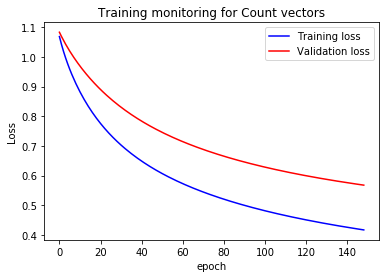

In [63]:
# Plot training and validation process 
plot_model_loss(loss_tr_count, dev_loss_count, model = 'Count vectors')

**Learning curve analysis:**

Both training and validation curve decrease to a rather low values, validation curve is classically higher then the training one. But the gap between two curves is not so big. So I would say that is the situation "about right".

In [64]:
# Compute accuracy, precision, recall and F1-scores
preds_te = predict_class(X_te_count, w_count)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.85
Precision: 0.852531599988124
Recall: 0.85
F1-Score: 0.8490235018906988


In [65]:
dict_labels = {1: 'World', 2: 'Sports', 3: 'Business'}
dict_labels

{1: 'World', 2: 'Sports', 3: 'Business'}

In [66]:
def print_top_word_multinomial(weights, dict_id_word = dict_id_word, class_to_show = 1, topN_words=10, dict_labels=dict_labels):
    # take the weights for each class and enumerate them 
    # so that further we can match a weight's index with the word it represents
    w_enumerated = list(enumerate(weights[class_to_show-1, :]))
    w_enumerated.sort(key = lambda x: x[1], reverse=True)
    topN_weights = w_enumerated[:topN_words]
    top_words = [dict_id_word[x[0]] for x in topN_weights]
    print("\nTop %i words for %i class (%s):" % (len(top_words), class_to_show, dict_labels[class_to_show]))
    print(top_words)

In [67]:
# Print the top-10 words for each class respectively.
for i in range(3):
    print_top_word_multinomial(w_count, class_to_show = i+1, topN_words=10)


Top 10 words for 1 class (World):
['afp', 'said', 'president', 'minister', 'najaf', 'people', 'monday', 'iraq', 'troops', 'al']

Top 10 words for 2 class (Sports):
['athens', 'olympic', 'ap', 'team', ('athens', 'reuters'), 'win', 'games', 'olympics', 'game', 'when']

Top 10 words for 3 class (Business):
['company', 'inc', 'oil', 'corp', 'billion', 'prices', 'business', 'sales', 'million', 'market']


### Choosing the right hyperparameters

#### Hyperparameters tuning for Bow-count

In [68]:
def check_ngram(X_tr_raw, X_dev_raw, X_test_raw, ngram_range=(1,3), vector_scheme = "count", capitalisation = True):
    """ Function to unite all previous models - data preprocesing with parameters to choose:
        ngram_range - default (1,3), 
        capitalisation - default = True,
        vector_scheme - count or tfidf
        """
    
    vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=ngram_range, keep_topN=5000, 
                                        stop_words=stop_words, capitalisation = capitalisation)
    X_ngram_tr = [extract_ngrams(x, ngram_range=ngram_range, stop_words=stop_words, 
                                 vocab=vocab, capitalisation = capitalisation) for x in X_tr_raw]
    X_ngram_dev = [extract_ngrams(x, ngram_range=ngram_range, stop_words=stop_words, 
                                  vocab=vocab, capitalisation = capitalisation) for x in X_dev_raw]
    X_ngram_test = [extract_ngrams(x, ngram_range=ngram_range, stop_words=stop_words, 
                                   vocab=vocab, capitalisation = capitalisation) for x in X_test_raw]
    
    dict_id_word = dict(enumerate(vocab))
    dict_word_id = {value:key for (key, value) in dict_id_word.items()}
    
    # vectorisation
    X_train = vectorise(X_ngram_tr, vocab, dict_word_id)
    X_dev = vectorise(X_ngram_dev, vocab, dict_word_id)
    X_test = vectorise(X_ngram_test, vocab, dict_word_id)
    if vector_scheme == "tfidf":
        vocab_df = np.array([df[word] for word in vocab])
        idf = np.log10(len(vocab)/vocab_df)
        X_train = X_train*idf
        X_dev = X_dev*idf
        X_test = X_test*idf
    
    return X_train, X_dev, X_test, dict_id_word


def test_parameters_multi(X_train, X_dev, Y_train, Y_dev, tolerance, reg_alpha, learning_rate, number_epochs=100,
                    vector_scheme = "count", print_top_words = True, print_progress= False):

    
    w, loss_train, loss_dev = SGD(X_train, Y_train, X_dev, Y_dev, num_classes=3, lr=learning_rate, 
                                    alpha = reg_alpha, epochs = number_epochs, tolerance= tolerance,
                                    print_progress = print_progress)
    
    plot_model_loss(loss_train, loss_dev, model = vector_scheme + ' vectors', scale_y = True, ylim=(0, 1), 
                    print_last_values=True)
    
    preds = predict_class(X_dev, w)
    accuracy = accuracy_score(Y_dev, preds)
    precision = precision_score(Y_dev, preds, average='macro')
    recall = recall_score(Y_dev, preds, average='macro')
    f1 = f1_score(Y_dev, preds, average='macro')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1)
    
    if print_top_words:
        print("\n%s vectors:" % vector_scheme)
        for i in range(3):
            print_top_word_multinomial(w_count, class_to_show = i+1, topN_words=10)
        
    return w, accuracy, precision, recall, f1

Number of all ngrams for term frequency calculation:  156261
Number of all sets of ngrams for doc frequency calculation:  154025

------------------------------
Regularisation is: 0.0001


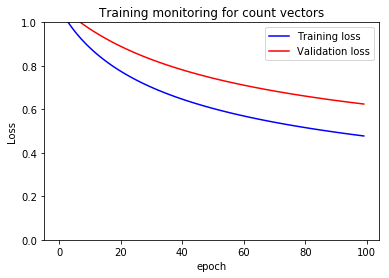


Training loss: [0.4829930738882241, 0.4811524171835574, 0.47933357907316426, 0.4775362958669038]
Validation loss: [0.6296072122133345, 0.6278575209787371, 0.6261281329893785, 0.62441931812287]
Accuracy: 0.8866666666666667
Precision: 0.8922532781228433
Recall: 0.8866666666666667
F1-Score: 0.8878941513712403

------------------------------
Regularisation is: 0.001


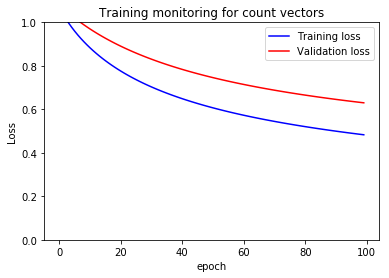


Training loss: [0.4882964852506933, 0.4865072750676446, 0.48473973084946514, 0.4829936624222745]
Validation loss: [0.6350165422705873, 0.6333249137816206, 0.6316534599954229, 0.6300024396689937]
Accuracy: 0.8866666666666667
Precision: 0.8922532781228433
Recall: 0.8866666666666667
F1-Score: 0.8878941513712403

------------------------------
Regularisation is: 0.01


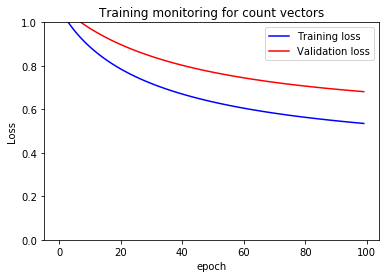


Training loss: [0.539011383209788, 0.5376995405061853, 0.5364073945953505, 0.5351357002477801]
Validation loss: [0.6848489798131574, 0.6836614815309187, 0.6824922846691568, 0.6813416515924916]
Accuracy: 0.8866666666666667
Precision: 0.8922532781228433
Recall: 0.8866666666666667
F1-Score: 0.8878941513712403

------------------------------
Regularisation is: 0.1
Convergence at epoch 36 for tolerance = 0.001000 has been reached


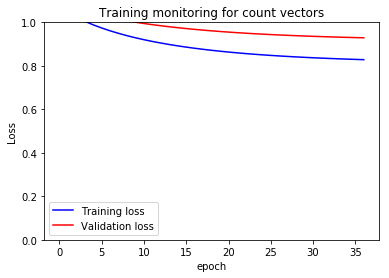


Training loss: [0.8323787803014495, 0.8309752817020023, 0.829655628909261, 0.828433619072532]
Validation loss: [0.9320513552758166, 0.9309747045649459, 0.929962940686378, 0.9290146095101681]
Accuracy: 0.8666666666666667
Precision: 0.8669014272375617
Recall: 0.8666666666666667
F1-Score: 0.8667253392005868

------------------------------
Regularisation is: 0.5
Convergence at epoch 10 for tolerance = 0.001000 has been reached


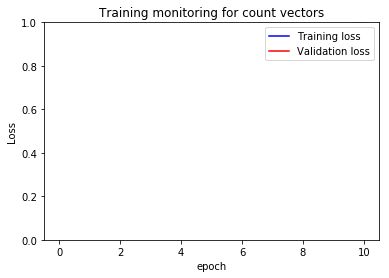


Training loss: [1.0098429518775451, 1.007555381509303, 1.0057924936764175, 1.004490818180638]
Validation loss: [1.0505940433212055, 1.0491721016153281, 1.0481067639818886, 1.0472392834082747]
Accuracy: 0.8666666666666667
Precision: 0.8688271604938271
Recall: 0.8666666666666667
F1-Score: 0.8670852956567243
           Precision    Recall  F1_Score
reg_0.0001  0.892253  0.886667  0.887894
reg_0.001   0.892253  0.886667  0.887894
reg_0.01    0.892253  0.886667  0.887894
reg_0.5     0.868827  0.866667  0.867085
reg_0.1     0.866901  0.866667  0.866725

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 87 for tolerance = 0.001000 has been reached


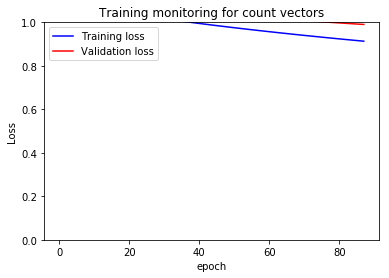


Training loss: [0.9178872079598254, 0.9163733486414191, 0.9148680776090197, 0.913371276047046]
Validation loss: [0.9933520174802584, 0.9923456003607051, 0.9913429306607817, 0.9903439494451489]
Accuracy: 0.8666666666666667
Precision: 0.8679994010182689
Recall: 0.8666666666666667
F1-Score: 0.8669376547323843

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 148 for tolerance = 0.001000 has been reached


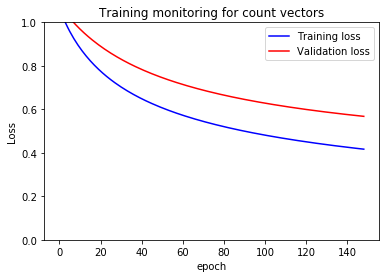


Training loss: [0.42001746439791066, 0.41893388318074226, 0.41785951034447116, 0.41679431487998225]
Validation loss: [0.5707640905747389, 0.5697546823450303, 0.5687541160204571, 0.5677624108882798]
Accuracy: 0.8933333333333333
Precision: 0.8986531986531987
Recall: 0.8933333333333334
F1-Score: 0.8944862155388472

------------------------------
Learning_rate is: 0.001
Convergence at epoch 64 for tolerance = 0.001000 has been reached


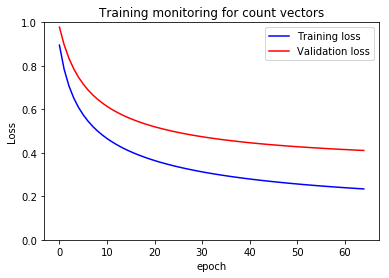


Training loss: [0.23816597692187902, 0.23673213484034658, 0.23533440476101716, 0.23397104594770507]
Validation loss: [0.4139801491985464, 0.41288292531129267, 0.41185410398789546, 0.4108652545993389]
Accuracy: 0.8933333333333333
Precision: 0.8986531986531987
Recall: 0.8933333333333334
F1-Score: 0.8944862155388472

------------------------------
Learning_rate is: 0.002
Convergence at epoch 46 for tolerance = 0.001000 has been reached


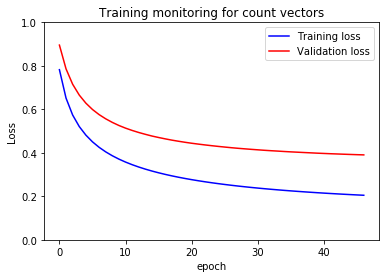


Training loss: [0.2094458814206397, 0.2078380907128817, 0.20629030637319384, 0.20480585116030334]
Validation loss: [0.3935483421757361, 0.3924699597018963, 0.3914431155528154, 0.39053194272867986]
Accuracy: 0.9
Precision: 0.9058578987150415
Recall: 0.9
F1-Score: 0.9011104089554934

------------------------------
Learning_rate is: 0.005
Convergence at epoch 27 for tolerance = 0.001000 has been reached


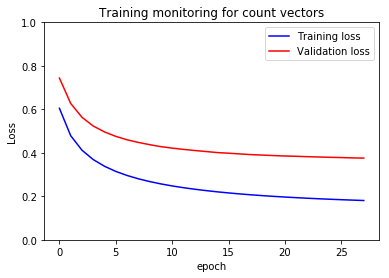


Training loss: [0.18652548103994487, 0.18445801651421806, 0.18249940586757296, 0.18072334296623704]
Validation loss: [0.37939639030909, 0.3781579865380938, 0.3766831992735676, 0.3757152944493598]
Accuracy: 0.9
Precision: 0.9034923705136472
Recall: 0.9
F1-Score: 0.9006615704701124
          Precision    Recall  F1_Score
lr_0.002   0.905858       0.9   0.90111
lr_0.005   0.903492       0.9  0.900662
lr_0.0001  0.898653  0.893333  0.894486
lr_0.001   0.898653  0.893333  0.894486
lr_1e-05   0.867999  0.866667  0.866938

------------------------------
Regularisation is: 0.0001
Convergence at epoch 58 for tolerance = 0.001000 has been reached


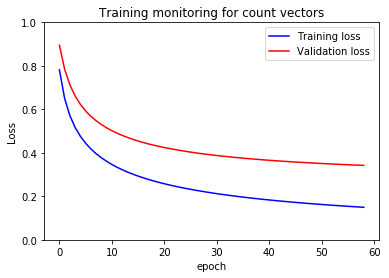


Training loss: [0.15404220049518116, 0.1524968732971186, 0.15098873842196053, 0.14951786339419273]
Validation loss: [0.3452568504379559, 0.3441644415837085, 0.3431608261318876, 0.3422145805888213]
Accuracy: 0.9
Precision: 0.9058578987150415
Recall: 0.9
F1-Score: 0.9011104089554934

------------------------------
Regularisation is: 0.001
Convergence at epoch 46 for tolerance = 0.001000 has been reached


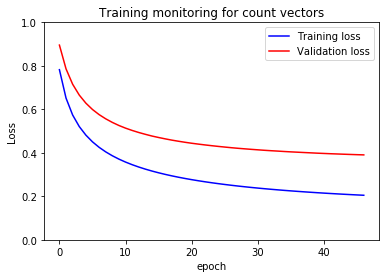


Training loss: [0.2094458814206397, 0.2078380907128817, 0.20629030637319384, 0.20480585116030334]
Validation loss: [0.3935483421757361, 0.3924699597018963, 0.3914431155528154, 0.39053194272867986]
Accuracy: 0.9
Precision: 0.9058578987150415
Recall: 0.9
F1-Score: 0.9011104089554934

------------------------------
Regularisation is: 0.01
Convergence at epoch 18 for tolerance = 0.001000 has been reached


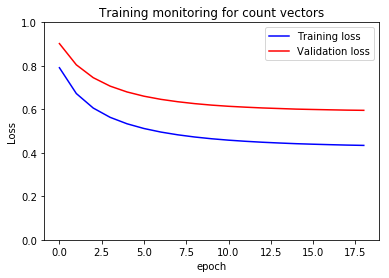


Training loss: [0.43961243889431795, 0.4374960691856494, 0.4355780029941452, 0.43415837805958585]
Validation loss: [0.5993379754123106, 0.5977953633785562, 0.5963321077519891, 0.5954148554621145]
Accuracy: 0.9066666666666666
Precision: 0.9101413615091426
Recall: 0.9066666666666667
F1-Score: 0.9076430442409823

------------------------------
Regularisation is: 0.1
Convergence at epoch 5 for tolerance = 0.001000 has been reached


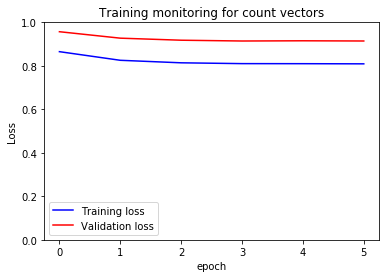


Training loss: [0.8139605414476507, 0.8102199626786493, 0.8099408189892807, 0.8092401620338524]
Validation loss: [0.917888755261325, 0.9142496077234076, 0.9152561598926898, 0.9143109991259885]
Accuracy: 0.8933333333333333
Precision: 0.8950756055131808
Recall: 0.8933333333333334
F1-Score: 0.893667634204117

------------------------------
Regularisation is: 0.5
Convergence at epoch 6 for tolerance = 0.001000 has been reached


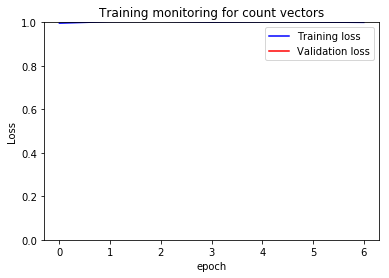


Training loss: [1.0012837296403725, 1.0023887384305772, 1.001362505062945, 0.9999920546210683]
Validation loss: [1.043739972016025, 1.0468237864609464, 1.0448148227226168, 1.045331440749545]
Accuracy: 0.8466666666666667
Precision: 0.852035561337887
Recall: 0.8466666666666667
F1-Score: 0.8469624408903346
           Precision    Recall  F1_Score
reg_0.01    0.910141  0.906667  0.907643
reg_0.0001  0.905858       0.9   0.90111
reg_0.001   0.905858       0.9   0.90111
reg_0.1     0.895076  0.893333  0.893668
reg_0.5     0.852036  0.846667  0.846962
Number of all ngrams for term frequency calculation:  156261
Number of all sets of ngrams for doc frequency calculation:  154481
Convergence at epoch 148 for tolerance = 0.001000 has been reached


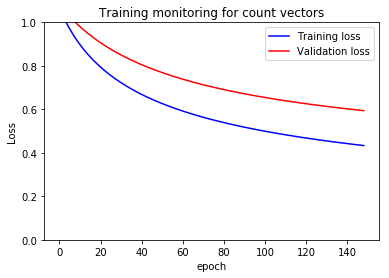


Training loss: [0.436662732613983, 0.43555178471938355, 0.43445016886385845, 0.433357843762579]
Validation loss: [0.5970021956607191, 0.5959889274534418, 0.5949843299314055, 0.5939884385367371]
Accuracy: 0.8933333333333333
Precision: 0.8961672848465302
Recall: 0.8933333333333332
F1-Score: 0.8935432050524179
CPU times: user 11min 30s, sys: 10.3 s, total: 11min 40s
Wall time: 8min 4s


In [69]:
%%time
vector_scheme = "count"
X_train_vect, X_dev_vect, X_test_vect, dict_id_word = check_ngram(X_tr_raw, X_dev_raw, X_te_raw, 
                    ngram_range=(1,3), vector_scheme = vector_scheme, capitalisation = True)

# !!! testing hyperparameters on validation set !!!
learing_rate_to_test = [0.00001, 0.0001, 0.001, 0.002, 0.005]
regularisation_to_test = [0.0001, 0.001, 0.01, 0.1, 0.5]
lr_columns= ["lr_"+str(i) for i in learing_rate_to_test]
reg_columns = ["reg_"+str(i) for i in regularisation_to_test]

# 1. Test different regularisation strength for default learning rate

parameter_tested = "Regularisation"
number_epochs = 200
tolerance=0.001
lr=0.0001
# alpha=0.001

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for alpha in regularisation_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", alpha)
    w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=100,  
                  vector_scheme = "count", print_top_words = False, print_progress= False)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

results = pd.DataFrame(index = reg_columns, columns = ["Precision", "Recall", "F1_Score"])
results.loc[reg_columns, "Precision"] = precision_scores
results.loc[reg_columns, "Recall"] = recall_scores
results.loc[reg_columns, "F1_Score"] = f1_scores
print(results.sort_values("F1_Score", ascending= False))

#2. Testing learning rate for default reg_0.001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0.001

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=number_epochs,  
                  vector_scheme = "count", print_top_words = False, print_progress= False)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1_Score"])
results.loc[lr_columns, "Precision"] = precision_scores
results.loc[lr_columns, "Recall"] = recall_scores
results.loc[lr_columns, "F1_Score"] = f1_scores
print(results.sort_values("F1_Score", ascending= False))

# 3. Test different regularisation strength for default learning rate

parameter_tested = "Regularisation"
number_epochs = 200
tolerance=0.001
lr=0.002
# alpha=0.001

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for alpha in regularisation_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", alpha)
    w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=number_epochs,  
                  vector_scheme = "count", print_top_words = False, print_progress= False)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

results = pd.DataFrame(index = reg_columns, columns = ["Precision", "Recall", "F1_Score"])
results.loc[reg_columns, "Precision"] = precision_scores
results.loc[reg_columns, "Recall"] = recall_scores
results.loc[reg_columns, "F1_Score"] = f1_scores
print(results.sort_values("F1_Score", ascending= False))

#4 Without capitalisation - compare with default

vector_scheme = "count"
X_train_vect_no, X_dev_vect_no, X_test_vect_no, dict_id_word_no = check_ngram(X_tr_raw, X_dev_raw, X_te_raw, 
                ngram_range=(1,3), vector_scheme = vector_scheme, capitalisation = False)

tolerance = 0.001
alpha = 0.001
lr = 0.0001
number_epochs = 200
w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect_no, X_dev_vect_no, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=number_epochs,  
                  vector_scheme = "count", print_top_words = False, print_progress = False)


Explain here...

Best parameters for Bow-Count found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8922  | 0.88866  | 0.8878 |
| best_found: tol = 0.001,reg = 0.001, lr=0.002 |  0.9058| 0.9  |  0.9011 |
| !!! best_found: tol = 0.001,reg = 0.01, lr=0.002 |  0.9101| 0.9066  |  0.9076 |
| default: tol = 0.001, reg = 0.001, lr=0.0001 (capitalisation = False)|  0.8961| 0.8933  |  0.8935 |
| !!! best_found: tol = 0.001,reg = 0.001, lr=0.002 (capitalisation = False) |  0.9135| 0.9133 |  0.9133 |
| best_found: tol = 0.001,reg = 0.01, lr=0.002 (capitalisation = False) |  0.9073| 0.9066  |  0.9065 |



In [70]:
# Testing best models (with capitalisation and without and compare with default which was calculated earlier)
tolerance = 0.001
alpha = 0.001
lr = 0.002
number_epochs = 200
w_no, loss_tr_count, dev_loss_count = SGD(X_train_vect_no, Y_tr, X_dev=X_dev_vect_no, Y_dev=Y_dev, num_classes=3,
                                          lr=lr, alpha=alpha, epochs=number_epochs, print_progress= False)

preds_te = predict_class(X_test_vect_no, w_no)
print("\nResults for Test data:")
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

for i in range(3):
    print_top_word_multinomial(w_no, class_to_show = i+1, topN_words=10)

tolerance = 0.001
alpha = 0.001
lr = 0.002
number_epochs = 200
w, loss_tr_count, dev_loss_count = SGD(X_train_vect, Y_tr, X_dev=X_dev_vect, Y_dev=Y_dev, num_classes=3,
                                          lr=lr, alpha=alpha, epochs=number_epochs, print_progress= False)

preds_te = predict_class(X_test_vect, w)
print("\nResults for Test data:")
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

for i in range(3):
    print_top_word_multinomial(w, class_to_show = i+1, topN_words=10)

Convergence at epoch 47 for tolerance = 0.001000 has been reached

Results for Test data:
Accuracy: 0.8633333333333333
Precision: 0.8663164365085518
Recall: 0.8633333333333333
F1-Score: 0.8627573962033264

Top 10 words for 1 class (World):
[('him', 'about'), ('homes', 'occupied', 'west'), 'must', ('foreign', 'minister', 'alexander'), ('eased', 'fears'), ('wall', 'street', 'estimates'), 'doubts', ('rose', 'last', 'week'), 'allen', ('became', 'second')]

Top 10 words for 2 class (Sports):
['prison', ('outlooks', 'wal', 'mart'), 'euro', ('night', 'game'), ('mortgage', 'finance'), ('send', 'troops'), ('earlier', 'avoid'), 'nbc', 'idea', 'adjusters']

Top 10 words for 3 class (Business):
['doping', 'returning', 'july', 'edwards', ('country', 'holiest'), ('oil', 'company'), ('four', 'private'), ('goog', 'oq'), ('medal', 'wednesday'), 'benefit']
Convergence at epoch 46 for tolerance = 0.001000 has been reached

Results for Test data:
Accuracy: 0.8644444444444445
Precision: 0.866394389064638
R

Best parameters for Bow-Count found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8922  | 0.88866  | 0.8878 |
| !!! best_found: tol = 0.001,reg = 0.01, lr=0.002 |  0.9101| 0.9066  |  0.9076 |
| !!! best_found: tol = 0.001,reg = 0.001, lr=0.002 (capitalisation = False) |  0.9135| 0.9133 |  0.9133 |


Best parameters for Test data:    

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8525  | 0.85  | 0.8490 |
| !!! best_found: tol = 0.001,reg = 0.01, lr=0.002 |  0.8663| 0.8644  |  0.8638 |
| !!! best_found: tol = 0.001,reg = 0.001, lr=0.002 (capitalisation = False) |  0.8663| 0.8633 |  0.8627 |

### Evaluation of BOW-tfidf

In [71]:
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr_tfidf, Y_tr, X_dev=X_dev_tfidf, 
                                             Y_dev=Y_dev, num_classes=3,lr=0.0001, 
                                             alpha=0.001, epochs=200)

Epoch 0: | Training loss: 1.000077, | Validation loss: 1.044966
Epoch 1: | Training loss: 0.926421, | Validation loss: 1.000056
Epoch 2: | Training loss: 0.866730, | Validation loss: 0.961029
Epoch 3: | Training loss: 0.816753, | Validation loss: 0.926621
Epoch 4: | Training loss: 0.774092, | Validation loss: 0.895961
Epoch 5: | Training loss: 0.737170, | Validation loss: 0.868447
Epoch 6: | Training loss: 0.704858, | Validation loss: 0.843592
Epoch 7: | Training loss: 0.676292, | Validation loss: 0.821032
Epoch 8: | Training loss: 0.650819, | Validation loss: 0.800420
Epoch 9: | Training loss: 0.627943, | Validation loss: 0.781532
Epoch 10: | Training loss: 0.607265, | Validation loss: 0.764145
Epoch 11: | Training loss: 0.588458, | Validation loss: 0.748085
Epoch 12: | Training loss: 0.571253, | Validation loss: 0.733180
Epoch 13: | Training loss: 0.555449, | Validation loss: 0.719327
Epoch 14: | Training loss: 0.540851, | Validation loss: 0.706384
Epoch 15: | Training loss: 0.527327

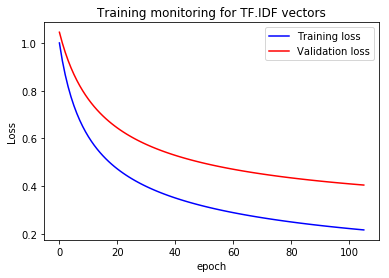

In [72]:
# plot training and validation learning curves
plot_model_loss(loss_tr_tfidf, dev_loss_tfidf, model = 'TF.IDF vectors')

**Observations**: 

I would say that it is sitution "about right", because Validation curve is higher that traing one, but the gap between them and final values from optimisation are quite low.

In [73]:
preds_te = predict_class(X_te_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8777777777777778
Precision: 0.8788839856970306
Recall: 0.8777777777777778
F1-Score: 0.8769892698230989


In [74]:
for i in range(3):
    print_top_word_multinomial(w_tfidf, class_to_show = i+1, topN_words=10)


Top 10 words for 1 class (World):
['afp', 'said', 'president', 'najaf', 'minister', 'leader', 'murder', 'monday', 'people', 'troops']

Top 10 words for 2 class (Sports):
['athens', 'ap', 'olympic', 'team', ('athens', 'reuters'), 'season', 'games', 'olympics', 'game', 'coach']

Top 10 words for 3 class (Business):
['company', 'inc', 'business', 'oil', 'corp', 'market', 'billion', 'million', 'sales', 'based']


#### Hyperparameters tuning for Bow-tfidf

Number of all ngrams for term frequency calculation:  156261
Number of all sets of ngrams for doc frequency calculation:  154025

------------------------------
Regularisation is: 0.0001


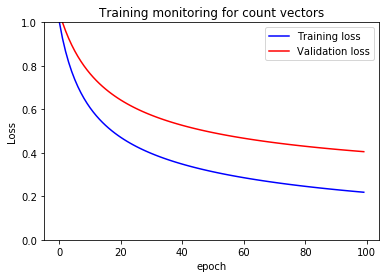


Training loss: [0.22250697544568065, 0.22122691615103174, 0.21996467155380733, 0.21871966883892147]
Validation loss: [0.40872867690605297, 0.40757268165645694, 0.40642862412151987, 0.40530488968608985]
Accuracy: 0.94
Precision: 0.9398532746431907
Recall: 0.94
F1-Score: 0.9398633196652998

------------------------------
Regularisation is: 0.001


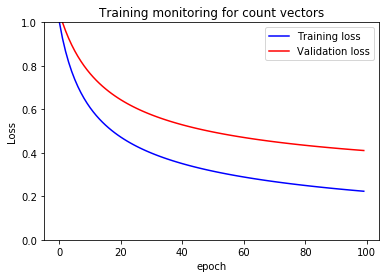


Training loss: [0.2270052967221694, 0.22576013553946073, 0.22453262971453025, 0.22332229024528055]
Validation loss: [0.4139041135980332, 0.4127901558374136, 0.41168782950790006, 0.4106057456101167]
Accuracy: 0.94
Precision: 0.9398532746431907
Recall: 0.94
F1-Score: 0.9398633196652998

------------------------------
Regularisation is: 0.01
Convergence at epoch 84 for tolerance = 0.001000 has been reached


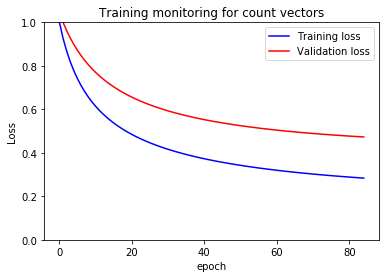


Training loss: [0.28724359852071674, 0.2860355179752737, 0.28485175682674335, 0.283692793651324]
Validation loss: [0.475920783016797, 0.4748909254468446, 0.4738836195465449, 0.472906721089125]
Accuracy: 0.94
Precision: 0.9398532746431907
Recall: 0.94
F1-Score: 0.9398633196652998

------------------------------
Regularisation is: 0.1
Convergence at epoch 35 for tolerance = 0.001000 has been reached


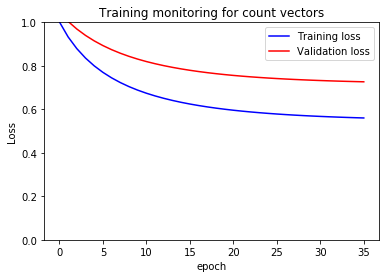


Training loss: [0.5642436396628376, 0.5628373638996756, 0.5615225392974827, 0.5603109625360785]
Validation loss: [0.729832310269979, 0.7286829220485767, 0.7276179380394197, 0.7266263594573789]
Accuracy: 0.94
Precision: 0.9399786581299185
Recall: 0.94
F1-Score: 0.93992799279928

------------------------------
Regularisation is: 0.5
Convergence at epoch 12 for tolerance = 0.001000 has been reached


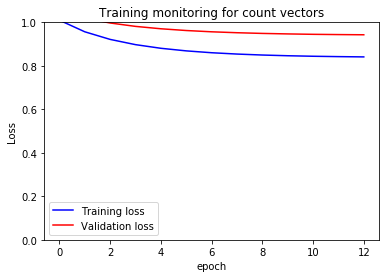


Training loss: [0.8465007544686353, 0.8441077626065745, 0.8424261260563932, 0.8411659106886282]
Validation loss: [0.9468398387147602, 0.9449919407911307, 0.9438095649535991, 0.9428999958656895]
Accuracy: 0.9266666666666666
Precision: 0.926470588235294
Recall: 0.9266666666666666
F1-Score: 0.9263824341617836
           Precision    Recall  F1_Score
reg_0.1     0.939979      0.94  0.939928
reg_0.0001  0.939853      0.94  0.939863
reg_0.001   0.939853      0.94  0.939863
reg_0.01    0.939853      0.94  0.939863
reg_0.5     0.926471  0.926667  0.926382

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 115 for tolerance = 0.001000 has been reached


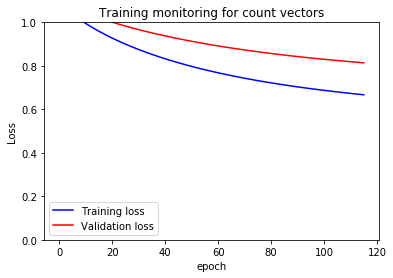


Training loss: [0.6707402832694678, 0.6694708177634044, 0.6682174640864871, 0.6669799085374127]
Validation loss: [0.8170399317156795, 0.8160277202951248, 0.8150273965521829, 0.8140386188101595]
Accuracy: 0.9333333333333333
Precision: 0.9330065359477123
Recall: 0.9333333333333332
F1-Score: 0.9329830942277901

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 35 for tolerance = 0.001000 has been reached


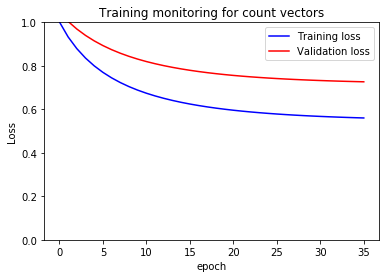


Training loss: [0.5642436396628376, 0.5628373638996756, 0.5615225392974827, 0.5603109625360785]
Validation loss: [0.729832310269979, 0.7286829220485767, 0.7276179380394197, 0.7266263594573789]
Accuracy: 0.94
Precision: 0.9399786581299185
Recall: 0.94
F1-Score: 0.93992799279928

------------------------------
Learning_rate is: 0.001
Convergence at epoch 7 for tolerance = 0.001000 has been reached


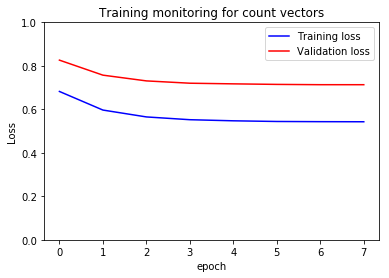


Training loss: [0.5472484548270777, 0.5441739549263822, 0.5432892192003963, 0.542841317951438]
Validation loss: [0.7171756398444522, 0.7146886196303349, 0.7133270001573936, 0.7132733791853368]
Accuracy: 0.94
Precision: 0.9399786581299185
Recall: 0.94
F1-Score: 0.93992799279928

------------------------------
Learning_rate is: 0.002
Convergence at epoch 6 for tolerance = 0.001000 has been reached


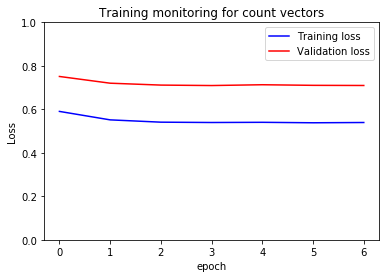


Training loss: [0.5394658775300929, 0.5403219310646514, 0.5381924065893211, 0.5394394922932642]
Validation loss: [0.7094427253940103, 0.7131252102441632, 0.7103807544833801, 0.709694794291769]
Accuracy: 0.9466666666666667
Precision: 0.9466666666666667
Recall: 0.9466666666666667
F1-Score: 0.9466666666666667

------------------------------
Learning_rate is: 0.005
Convergence at epoch 2 for tolerance = 0.001000 has been reached


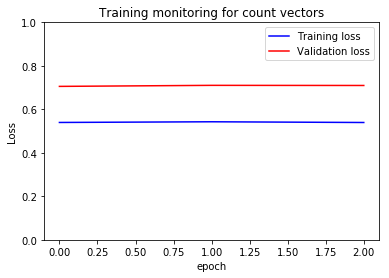


Training loss: [0.5396464409395912, 0.542807149984833, 0.5394687203032318]
Validation loss: [0.7055571398194456, 0.7103256705839789, 0.7097355205124519]
Accuracy: 0.9466666666666667
Precision: 0.9463631606488749
Recall: 0.9466666666666667
F1-Score: 0.9463260051495345
          Precision    Recall  F1_Score
lr_0.002   0.946667  0.946667  0.946667
lr_0.005   0.946363  0.946667  0.946326
lr_0.0001  0.939979      0.94  0.939928
lr_0.001   0.939979      0.94  0.939928
lr_1e-05   0.933007  0.933333  0.932983

------------------------------
Learning_rate is: 1e-05
Convergence at epoch 187 for tolerance = 0.001000 has been reached


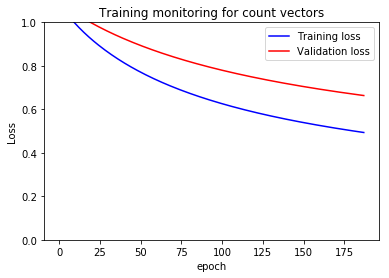


Training loss: [0.49676176529688093, 0.49565945799845196, 0.4945641617589973, 0.4934758432310296]
Validation loss: [0.6664814691220506, 0.6654717029241086, 0.6644677721169081, 0.663469613858241]
Accuracy: 0.94
Precision: 0.9399786581299185
Recall: 0.94
F1-Score: 0.93992799279928

------------------------------
Learning_rate is: 0.0001
Convergence at epoch 108 for tolerance = 0.001000 has been reached


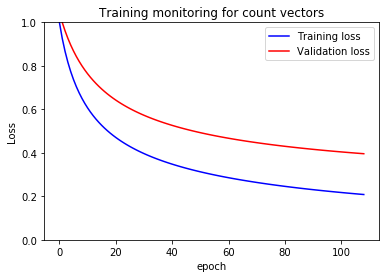


Training loss: [0.21159333007673417, 0.21045946844512875, 0.20934011109506043, 0.20823512944286743]
Validation loss: [0.39889879375306303, 0.3978840673862245, 0.39688364837579465, 0.39589350047476113]
Accuracy: 0.94
Precision: 0.9398532746431907
Recall: 0.94
F1-Score: 0.9398633196652998

------------------------------
Learning_rate is: 0.001
Convergence at epoch 42 for tolerance = 0.001000 has been reached


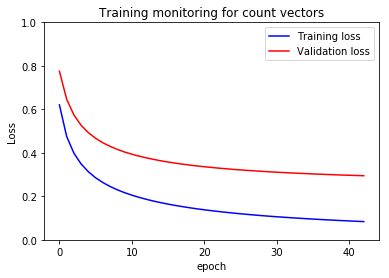


Training loss: [0.08828866748461718, 0.08670632863127446, 0.08517396835934314, 0.0837018827744935]
Validation loss: [0.2978420496513884, 0.29676139160641785, 0.295735006099974, 0.29475223238862974]
Accuracy: 0.9266666666666666
Precision: 0.9273717948717949
Recall: 0.9266666666666666
F1-Score: 0.9267760437508338

------------------------------
Learning_rate is: 0.002
Convergence at epoch 28 for tolerance = 0.001000 has been reached


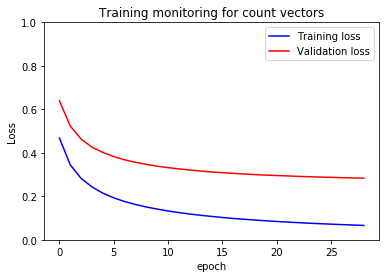


Training loss: [0.071837717714508, 0.06986833984119709, 0.06795139069047605, 0.066078861214065]
Validation loss: [0.28716908367646016, 0.28569417896533095, 0.2844809977131811, 0.2835425067182435]
Accuracy: 0.9266666666666666
Precision: 0.9273717948717949
Recall: 0.9266666666666666
F1-Score: 0.9267760437508338

------------------------------
Learning_rate is: 0.005
Convergence at epoch 15 for tolerance = 0.001000 has been reached


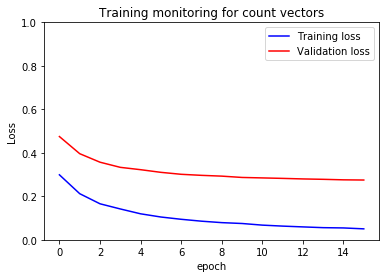


Training loss: [0.05932351522752843, 0.055835452682128875, 0.054551444022390594, 0.050345141293754565]
Validation loss: [0.2799251019367808, 0.2781496436562812, 0.2757840093631261, 0.2748891990990106]
Accuracy: 0.92
Precision: 0.9207221350078493
Recall: 0.9199999999999999
F1-Score: 0.9201822142998615
          Precision    Recall  F1_Score
lr_1e-05   0.939979      0.94  0.939928
lr_0.0001  0.939853      0.94  0.939863
lr_0.001   0.927372  0.926667  0.926776
lr_0.002   0.927372  0.926667  0.926776
lr_0.005   0.920722      0.92  0.920182
CPU times: user 9min 54s, sys: 8.16 s, total: 10min 3s
Wall time: 6min 41s


In [75]:
%%time
vector_scheme = "tfidf"
X_train_vect, X_dev_vect, X_test_vect, dict_id_word = check_ngram(X_tr_raw, X_dev_raw, X_te_raw, 
                                                   ngram_range=(1,3), vector_scheme = vector_scheme, 
                                                                  capitalisation = True)

# !!! testing hyperparameters on validation set !!!
learing_rate_to_test = [0.00001, 0.0001, 0.001, 0.002, 0.005]
regularisation_to_test = [0.0001, 0.001, 0.01, 0.1, 0.5]
lr_columns= ["lr_"+str(i) for i in learing_rate_to_test]
reg_columns = ["reg_"+str(i) for i in regularisation_to_test]
# columns_for_results = lr_columns+reg_columns


# 1. Test different regularisation strength for default learning rate

parameter_tested = "Regularisation"
number_epochs = 200
tolerance=0.001
lr=0.0001
# alpha=0.001

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for alpha in regularisation_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", alpha)
    w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=100,  vector_scheme = "count",
                  print_top_words = False, print_progress= False)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

results = pd.DataFrame(index = reg_columns, columns = ["Precision", "Recall", "F1_Score"])
results.loc[reg_columns, "Precision"] = precision_scores
results.loc[reg_columns, "Recall"] = recall_scores
results.loc[reg_columns, "F1_Score"] = f1_scores
print(results.sort_values("F1_Score", ascending= False))

#2. Testing learning rate for default reg_0.001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0.1

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=number_epochs,  
                  vector_scheme = "count",  print_top_words = False, print_progress= False)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1_Score"])
results.loc[lr_columns, "Precision"] = precision_scores
results.loc[lr_columns, "Recall"] = recall_scores
results.loc[lr_columns, "F1_Score"] = f1_scores
print(results.sort_values("F1_Score", ascending= False))

#3. Testing learning rate for default reg_0.001
parameter_tested = "Learning_rate"

number_epochs = 200
tolerance=0.001
# lr=0.0001
alpha=0.0001

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for lr in learing_rate_to_test:
    print('\n------------------------------')
    print(parameter_tested + " is:", lr)
    w, accuracy, precision, recall, f1 = test_parameters_multi(X_train_vect, X_dev_vect, Y_tr, Y_dev,  
                  tolerance = tolerance, reg_alpha=alpha, learning_rate= lr, number_epochs=number_epochs,  
                  vector_scheme = "count", print_top_words = False, print_progress= False)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

results = pd.DataFrame(index = lr_columns, columns = ["Precision", "Recall", "F1_Score"])
results.loc[lr_columns, "Precision"] = precision_scores
results.loc[lr_columns, "Recall"] = recall_scores
results.loc[lr_columns, "F1_Score"] = f1_scores
print(results.sort_values("F1_Score", ascending= False))

Best parameters for Bow-tfidf found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.9398  | 0.94  | 0.9398 |
| best_found: tol = 0.001,reg = 0.1, lr=0.002|  0.9466| 0.9466  |  0.9466 |
| best_found: tol = 0.001,reg = 0.001, lr=0.002|  0.9466| 0.9466  |  0.9466 |

In [76]:
# Testing on test data
tolerance = 0.001
alpha = 0.1
lr = 0.002
number_epochs = 200
w, loss_tr_count, dev_loss_count = SGD(X_train_vect, Y_tr, X_dev=X_dev_vect, Y_dev=Y_dev, num_classes=3,
                                          lr=lr, alpha=alpha, epochs=number_epochs, print_progress= False)

preds_te = predict_class(X_test_vect, w)
print("\nResults for Test data:")
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
for i in range(3):
    print_top_word_multinomial(w, class_to_show = i+1, topN_words=10)

Convergence at epoch 6 for tolerance = 0.001000 has been reached

Results for Test data:
Accuracy: 0.8711111111111111
Precision: 0.8725227474665678
Recall: 0.8711111111111111
F1-Score: 0.870020339304173

Top 10 words for 1 class (World):
['afp', 'minister', 'najaf', 'people', 'said', 'president', 'iraq', 'troops', 'murder', 'al']

Top 10 words for 2 class (Sports):
['athens', 'olympic', 'team', ('athens', 'reuters'), 'ap', 'games', 'olympics', 'game', 'win', 'season']

Top 10 words for 3 class (Business):
['company', 'inc', 'oil', 'billion', 'corp', 'prices', 'market', 'business', 'google', 'sales']


Best parameters for Bow-tfidf found on validation set!!!

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.9398  | 0.94  | 0.9398 |
| best_found: tol = 0.001,reg = 0.1, lr=0.002|  0.9466| 0.9466  |  0.9466 |

Best parameters for Bow-tfidf found on Test data

| parameters | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| default: tol = 0.001, reg = 0.001, lr=0.0001 | 0.8788  | 0.8777  | 0.8769 |
| best_found: tol = 0.001,reg = 0.1, lr=0.002|  0.8725| 0.8711  |  0.8700 |

!!! **Note:** I used two models in for test data, but the first one with defalt values as a benchmark, 
so for the final section I provide results for the model that was chosen considering its performance on validation set!!!

Answer 2:
<br>**What is the relation between training epochs and learning rate?**
<br>Answer: as it can be seen from our data, the number of training epochs required for convergence decreases with increase of learning rate. However, after a certain value (when learning rate starts to be too high for the current model), we can "jump" through the optimal minimum, so it the convergence cannot appear during further training.
<br>**How the regularisation strength affects performance?**
<br>Answer: In the begining, increasing of regularisation parameter slightly improves model performance, but then starts to do the opposite.

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.8663| 0.8644  |  0.8638 |
| BOW-tfidf  |  0.8725|   0.8711|  0.8700 |
